# Revealing representative "typical" day-types using traffic data observation and clustering

This exercise can be divided to two parts. Both give you the toolsets of methods for exploring, visualazing and evaluating day clusterings.

## Data preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

#upload the dataset by downloading both datasets from canvas and upload it on colab

# data_df = pd.read_csv("dataset_exercise_5_clustering_highway_traffic.csv",sep=";")
# data_df

file_path = "/content/drive/MyDrive/dataset_exercise_5_clustering_highway_traffic.csv"

data_df = pd.read_csv(file_path, sep=";")
data_df

,PORTAL,Date,time_from,time_to,Interval_5,SPEED_MS_AVG,flow
0,"E4S 56,780",20210101,00:00:00,00:05:00,0,18.56,39
1,"E4S 56,780",20210101,00:05:00,00:10:00,1,20.39,18
2,"E4S 56,780",20210101,00:10:00,00:15:00,2,19.27,26
3,"E4S 56,780",20210101,00:15:00,00:20:00,3,19.52,52
4,"E4S 56,780",20210101,00:20:00,00:25:00,4,20.52,52
...,...,...,...,...,...,...,...
104838,"E4S 56,780",20211231,23:35:00,23:40:00,283,19.58,115
104839,"E4S 56,780",20211231,23:40:00,23:45:00,284,19.47,87
104840,"E4S 56,780",20211231,23:45:00,23:50:00,285,19.77,130
104841,"E4S 56,780",20211231,23:50:00,23:55:00,286,18.79,129


Your objective here is to reveal representative day-type clusters; hence, we cluster days. The provided dataset is 5-minute observations on highway microwave sensors and needs to be in a format ready for day clustering. Thus, we represent days as ordered vectors of day-time observations of size 288 (there are 288, 5-minute time observations)

In [3]:
# Sort the DataFrame 'data_df' by columns "Date" and "Interval_5"
data_df.sort_values(["Date", "Interval_5"])

# Extract unique dates from the sorted DataFrame
days = np.unique(data_df[['Date']].values.ravel())
# Calculate the total number of unique days
ndays = len(days)

# Group the DataFrame 'data_df' by the "Date" column
day_subsets_df = data_df.groupby(["Date"])

# Define the total number of 5-minute intervals in a day
nintvals = 288

# Create a matrix 'vectorized_day_dataset' filled with NaN values
vectorized_day_dataset = np.zeros((ndays, nintvals))
vectorized_day_dataset.fill(np.nan)

# Loop through each unique day
for i in range(0, ndays):
    # Get the DataFrame corresponding to the current day
    df_t = day_subsets_df.get_group(days[i])

    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):
        # Get the current day's DataFrame
        df_t = day_subsets_df.get_group(days[i])

        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset'
        vectorized_day_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

# Print the resulting 'vectorized_day_dataset'
print(vectorized_day_dataset)

[[ 39.  18.  26. ...  32.  39.  34.]
 [ 30.  32.  27. ...  44.  41.  39.]
 [ 36.  44.  52. ...  50.  45.  23.]
 ...
 [ 20.  34.  31. ...  38.  42.  36.]
 [ 36.  40.  25. ...  38.  56.  35.]
 [ 33.  32.  34. ... 130. 129. 117.]]


* STEP 1: We ensure the ordering of days and intervals is proper. The data integer representation and indexing of time intervals allow a simple order of data.
* STEP 2: We get all unique days in the dataset to know the number and their list
* STEP 3: We could do the same of time-intervals, but here we know it is 288
* STEP 4: We create new datasets where rows are days and columns are day-time interval observations. *Note that if you plan to reveal network-wide day-types, this day vector can be ordered vector of SENSORS * TIME-INTERVALS.*
* STEP 5: fill in data to the right indexes.

# Part 1: Data exploration

It is always good practice to explore data you work with for outliers or pattern existence, as it can impact the revealed patterns and their predictions.

In [4]:

print('number of nans',np.sum(np.isnan(vectorized_day_dataset)))
print('rate of nans',np.sum(np.isnan(vectorized_day_dataset))/(ndays*nintvals))

number of nans 277
rate of nans 0.0026350837138508373


In the dataset, we have only missing 277 values, which is 0.26%. Let us check its distribution in the dataset. First, missing data could be related to night hours, with a higher possibility of no vehicle observations.

(288,)


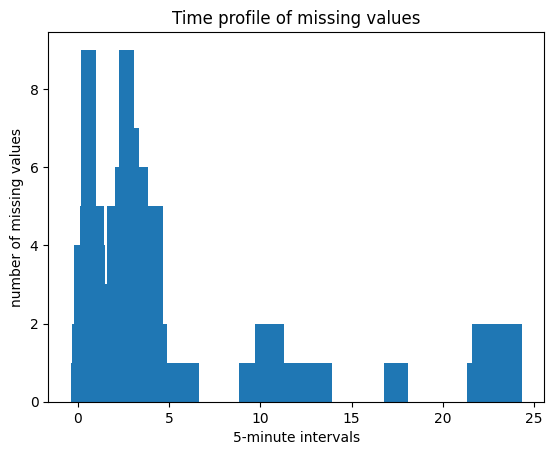

In [5]:
nans_per_time = np.sum(np.isnan(vectorized_day_dataset),0)
print(nans_per_time.shape)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# Create an array 'x_axis' representing the 5-minute intervals
x_axis = np.arange(0, nintvals, 1, dtype=int)
# Initialize an empty list 'x_axis_hours' to store time values in hours
x_axis_hours = []
# Convert interval indices to hours and append them to 'x_axis_hours'
for i in range(0, len(x_axis)):
  x_axis_hours.append(float(x_axis[i]*5)/60)
ax.bar(x_axis_hours,height=nans_per_time)


ax.set_ylabel('number of missing values')
ax.set_xlabel('5-minute intervals')
ax.set_title('Time profile of missing values')

plt.show()

Are these missing values associated with just a few days?

In [6]:
nans_per_day = np.sum(np.isnan(vectorized_day_dataset),1)
print('number of days with missing value',np.size(np.where(nans_per_day > 0),1))

number of days with missing value 28


What does the data look like? What is the traffic pattern? Below is the script that can help you visualize all days where overlapping transparencies highlight some patterns. The black line is the average yearly flow for a time interval.

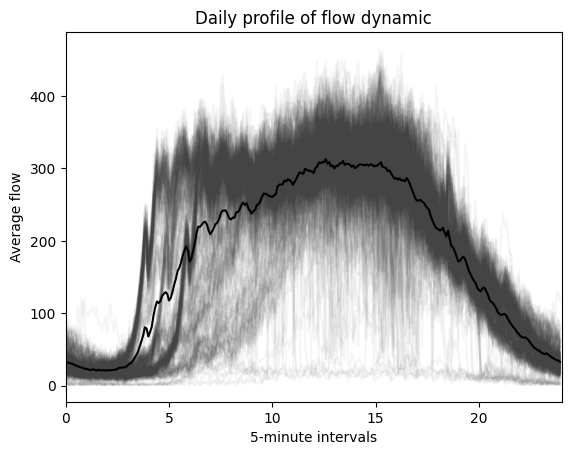

In [7]:
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()# a convenient way to create a new figure and a set of subplots.
ax.plot(np.array([x_axis_hours,]*ndays).transpose(),vectorized_day_dataset.transpose(),color='#444444',alpha=0.05)
# Above line plots the dataset with specified color and transparency.
ax.plot(x_axis_hours,np.transpose(np.nanmean(vectorized_day_dataset,0)),color='black')
# Above line plots the average of the dataset in black color.

ax.set_ylabel('Average flow')
ax.set_xlabel('5-minute intervals')
plt.xlim(0,24)
ax.set_title('Daily profile of flow dynamic')

plt.show()

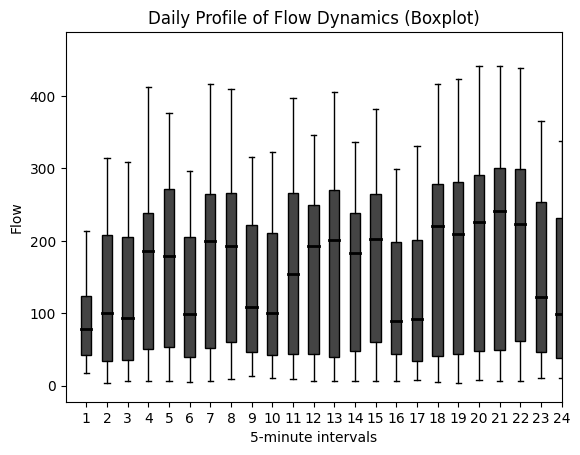

In [8]:
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()  # This line is a convenient way to create a new figure and a set of subplots.

# Create a boxplot for the dataset
boxplot = ax.boxplot(vectorized_day_dataset.T, patch_artist=True)

# Customize the boxplot appearance
for patch in boxplot['boxes']:
    patch.set_facecolor('#444444')  # Set the box color to gray
for median in boxplot['medians']:
    median.set(color='black', linewidth=2)  # Set median line color to black

# Set the y-axis label
ax.set_ylabel('Flow')

# Set the x-axis label
ax.set_xlabel('5-minute intervals')

# Set the x-axis limits to be between 0 and 24
plt.xlim(0, 24)

# Set the title of the plot
ax.set_title('Daily Profile of Flow Dynamics (Boxplot)')

# Display the plot
plt.show()

Some patterns are obvious, and we could expect some peak and weekend patterns. Thus, a simple thing to do is look at day-of-week patterns, done below.

In [9]:
import datetime

# Create an array 'day_of_week' to store the day of the week for each unique date
day_of_week = np.zeros((ndays))

# Loop through each unique date
for i in range(0, ndays):
    # Parse the current date from a string to a datetime object
    day_dt = datetime.datetime.strptime(str(days[i]), '%Y%m%d')

    # Get the day of the week (1 for Monday, 2 for Tuesday, ..., 7 for Sunday)
    day_of_week[i] = day_dt.isoweekday()

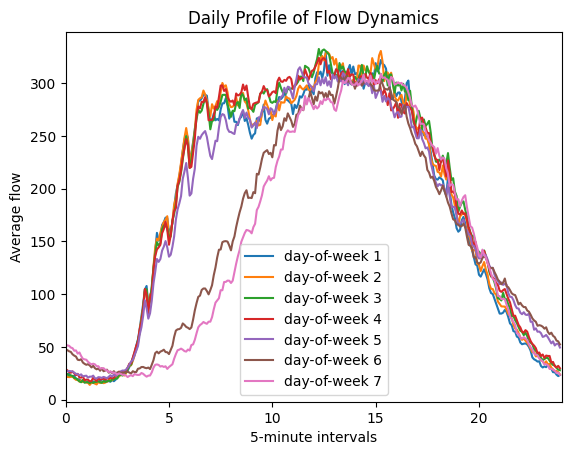

In [10]:
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()

# Iterate through each day of the week (from 1 to 7)
for i in range(1, 8):
    # Find the indices of days that correspond to the current day of the week
    day_of_week_index_t = np.where(day_of_week == i)

    # Calculate the number of days that match the current day of the week
    ndays_t = np.size(day_of_week_index_t[0])

    # Plot the average flow for the current day of the week
    ax.plot(x_axis_hours,
            np.nanmean(vectorized_day_dataset[day_of_week_index_t[0], :].transpose(), 1),
            label='day-of-week ' + str(i))
    # This line plots the average flow for the current day of the week.
    # 'np.nanmean()' calculates the mean while handling NaN values.

# Set the y-axis label
ax.set_ylabel('Average flow')

# Set the x-axis label
ax.set_xlabel('5-minute intervals')

# Set the x-axis limits to be between 0 and 24
plt.xlim(0, 24)

# Set the title of the plot
ax.set_title('Daily Profile of Flow Dynamics')

# Add a legend indicating the day of the week
ax.legend()

# Display the plot
plt.show()

The day's index is from 1 - 7, where 1 is Monday. To our expectations, we can see the difference between weekdays and weekends. However, some patterns from the previous plot are missing here and may include seasonal, holiday, and incident impacts on observations. This we explore with clustering in the next part of the exercise.

# Part 2: Clustering

In this part, you will work on revealing patterns using traffic observations and clustering methods.

## Clustering

Using clustering methods in scikit-learn is relatively simple, as shown below. With one line of code, you can get some clusters. However, this will need some work to search for representative clusters. This is the first step to pattern exploration.

In [11]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

#clusters = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(vectorized_day_dataset)


As you can see k-means clustering method can not handle missing values, so you have choices: impute data or remove them. We will just remove all days that have missing observations. Fewer days would be removed if we restrict the clustering to a particular day-time period, 06:00 - 22:00:00. Below, we prepare a new dataset without missing values and update the list of days for later visualization purposes.

In [12]:
n_clusters = 10
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

# BELOW lines enables you to comment in and out clustering method you want to use note that GMM have different ouput and thus labels are extracted differently
clusters = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
#clusters = DBSCAN(eps=500, min_samples = 2).fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

if clusters is not None:
  cluster_labels = clusters.labels_

#cluster_labels = GaussianMixture(n_components=n_clusters).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans) #check the parameters at  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py


print(cluster_labels)

[4 4 4 9 1 4 9 9 4 4 9 9 9 9 9 4 4 9 3 3 3 3 4 4 9 9 9 9 4 4 9 9 9 9 9 4 4
 9 9 9 9 3 4 4 9 3 3 3 4 4 3 3 3 3 4 4 3 3 9 3 9 4 4 3 9 3 9 3 4 4 3 3 3 3
 3 4 4 3 3 9 3 3 4 3 3 4 4 4 4 9 3 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3
 3 3 3 4 1 2 2 2 2 2 1 1 2 2 6 8 8 1 1 2 2 1 1 2 2 2 2 2 1 1 2 2 6 2 6 1 1
 2 2 6 6 6 1 1 2 6 2 2 8 1 1 2 2 6 2 1 4 1 6 8 2 0 8 1 7 8 6 8 1 1 8 8 8 8
 8 1 1 8 8 8 8 8 1 1 8 8 1 1 8 8 8 7 1 1 8 8 8 2 6 1 1 2 2 2 2 6 1 1 2 2 2
 6 6 1 1 2 2 2 2 6 1 2 1 1 2 2 6 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2 7 2 2 2 1 1
 2 2 2 2 6 1 1 2 2 2 6 8 1 1 6 2 2 2 1 1 5 5 5 5 4 1 5 5 5 5 1 1 5 5 5 5 5
 1 1 5 5 5 5 5 1 4 5 5 5 5 5 4 4 5 5 5 9 1 4 5 5 5 5 5 1 4 5 5 5 8 4 4 4 1
 1 1 1 4]


## Visualizaiton of representative day-type patterns

### Special plots for visualizing day-type patterns

the results of clusterings are assignments to the clusters, this can be hard to read and make conclusions about it, so visualization of data in right way is of high importance. Below script gives you set of libraries for calendar and centroid visualizaiton.

***Note: The below script you do not have to understand. Consider it as an external library that will plot for you, just like a histogram plot, for which you also do not know the exact implementation. Anyway, this course does not focus on information visualization.***

In [13]:

from dateutil.relativedelta import relativedelta
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib import colors

def assign_colors(n_clusters, days, assigments):

    days_colors = []
    color_to_cluster = []
    style_to_cluster = []
    weekend_colors = ['#67001f','#d6604d','#fdae61','#f46d43','#d53e4f','#9e0142','#f768a1','#f1c232']#,'#fe9929','#cc4c02','#e31a1c','#737373','#bdbdbd','#252525','#bcbddc']
#    weekend_school_colors = ['#c2a5cf','#f1b6da','#8e0152','#c51b7d','#de77ae','#ae017e','#fcc5c0','#e31a1c','#737373','#bdbdbd']
#    bank_holidays_colors = ['#543005','#dfc27d','#bf812d','#8c510a']
    mixed_colors = ['#4d4d4d','#35978f','#bababa','#878787']
    weekday_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#cab2d6','#6a3d9a','#b15928','#8dd3c7','#bebada','#fb8072','#b3de69','#bc80bd','#fccde5','#ccebc5','#35978f','#80cdc1']

    cluster_id_weekdays_share = []
    cluster_id_weekend_share = []
    cluster_id_all_days = []

    for i in range(0,n_clusters):
        color_to_cluster.append(None)
        style_to_cluster.append(None)
        cluster_id_weekdays_share.append(0)
        cluster_id_weekend_share.append(0)
        cluster_id_all_days.append(0)

    for i in range(0,len(days)):
        #print(i,assigments[i],len(assigments),len(cluster_id_all_days))
        if assigments[i] is not None:
            cluster_id_all_days[assigments[i]] += 1
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')

            if int(pomT.weekday()) < 5:
                cluster_id_weekdays_share[assigments[i]] += 1
            else:
                cluster_id_weekend_share[assigments[i]] += 1

    print('cluster_id_weekdays_share',cluster_id_weekdays_share)
    print('cluster_id_weekend_share',cluster_id_weekend_share)
    for i in range(0,len(days)):
        if assigments[i] is not None:
            cluster_idx = assigments[i]
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
            if color_to_cluster[assigments[i]] is None:
                if cluster_id_weekend_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekend_colors.pop()
                        style_to_cluster[assigments[i]] = ':'
                elif cluster_id_weekdays_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekday_colors.pop(0)
                        style_to_cluster[assigments[i]] = '-'
                else:
                    color_to_cluster[assigments[i]] = mixed_colors.pop()
                    style_to_cluster[assigments[i]] = ':'

            days_colors.append(color_to_cluster[assigments[i]])
        else:
            days_colors.append(None)

    return days_colors,color_to_cluster,style_to_cluster


def calmap(ax, year, data, days, assigments, n_clusters,days_colors,color_to_cluster,
           limit_graphics=False):

    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders

    xticks, labels = [], []
    start = datetime.datetime(year,1,1).weekday()

    for month in range(1,13):

        first = datetime.datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]

        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",

                       linewidth=1, zorder=20, clip_on=False)

        ax.add_artist(poly)

    line = Line2D([0,53],[5,5],linewidth=1, zorder = 20,color="black",linestyle='dashed')
    ax.add_artist(line)

    if not limit_graphics:
        ax.set_xticks(xticks)
        ax.set_xticklabels(labels)
        ax.set_yticks(0.5 + np.arange(7))
        ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
        ax.set_title("{}".format(year), weight="semibold")
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False)

    # Clearing first and last day from the data
    valid = datetime.datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime.datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    for i in range(0,len(days)):
        if '-' in str(days[i]):
            pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
        else:
            pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
        week_number = int(pomT.strftime("%W"))
        day_of_week = int(pomT.weekday())
        data[day_of_week,week_number] = assigments[i]


    act_date = datetime.datetime(year,1,1)
    while (act_date.year == year):

        week_number = int(act_date.strftime("%W"))
        day_of_week = int(act_date.weekday())
        doy_id = act_date.timetuple().tm_yday
        if doy_id<5 and week_number > 53:
            week_number = 0

        act_date = act_date + datetime.timedelta(days=1)

    #pomT = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
    #week_number = int(pomT.strftime("%V"))
    #day_of_week = int(pomT.weekday())
    #print(week_number,day_of_week)
    #doy_id = pomT.timetuple().tm_yday
    #if doy_id<5 and week_number > 0:
    #    week_number = 0
    #data[day_of_week,week_number] = len(clusters)+10

    # Showing data
    cmap = plt.cm.spring  # Can be any colormap that you want after the cm
    cmap.set_bad(color='white')

    #ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=0, vmax=len(clusters)+10,
    #          cmap=cmap, origin="lower", alpha=.75)

    cmap = colors.ListedColormap(color_to_cluster)
    bounds=[-0.1]
    step = 1
    for i in range(0,n_clusters):
        bounds.append(i-0.1+step)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    #print(color_to_cluster)
   #print(bounds)
    #print(norm)

    #print(color_to_cluster)
    #print(bounds)
    #print(cmap)
    #exit(0)

    ax.imshow(data, extent=[0,53,0,7], zorder=10, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)

def make_calendar_visualization_figure(days,assigments,n_clusters,years,days_colors,color_to_cluster,
                                       save_figure: str = None, show_figure:bool = True, limit_graphics = False):

    fig = plt.figure(figsize=(8,1.5*len(years)), dpi=100)
    X = np.linspace(-1,1, 53*7)

    for i, obj in enumerate(years):

        pom_s = str(len(years))+'1'+str(i+1)
        print(pom_s)

        ax = plt.subplot(int(pom_s), xlim=[0, 53], ylim=[0, 7], frameon=False, aspect=1)
        I = 1.2 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
        I = I.reshape(53,7).T
        I.fill(np.nan)
        calmap(ax, int(obj), I.reshape(53,7).T, days, assigments, n_clusters,days_colors,color_to_cluster, limit_graphics)

    #   ax = plt.subplot(212, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #  I = 1.1 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #   calmap(ax, 2018, I.reshape(53,7).T)

    #ax = plt.subplot(313, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #I = 1.0 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #calmap(ax, 2019, I.reshape(53,7).T)
    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()


def make_figure_centroids(x,y,color_to_cluster,style_to_cluster,cluster_ids,minY = None,maxY = None,
                          save_figure: str = None, show_figure:bool = True):

    #print(color_to_cluster)
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    for i in range(0,len(x)):
        #print(i,color_to_cluster[i],style_to_cluster[i])
        #print(y[i])
        ax.plot(x[i],y[i],style_to_cluster[i], color=color_to_cluster[i], label=str(cluster_ids[i]))
    ax.set_xlabel('Time of day')
    ax.set_ylabel('Flow')
    if minY is not None and maxY is not None:
        ax.set_ylim([minY, maxY])
    plt.legend()

    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()



### Visualization

#### Calendar visualization

Using above functions for visualization, the representative day-type clusters can be visualize in form of calendar in order to enable for us by-eye analysis to make sense of these clusters. What is your reflection about them? Note that white cells are removed days because of missing observations

cluster_id_weekdays_share [1, 6, 65, 47, 6, 34, 19, 1, 27, 30]
cluster_id_weekend_share [0, 56, 0, 0, 43, 0, 0, 2, 0, 0]
111


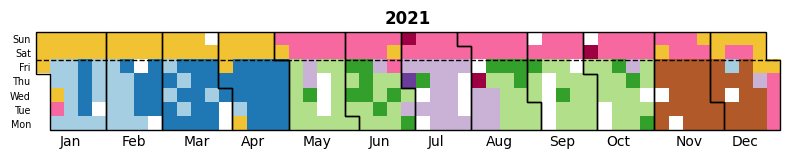

In [14]:
# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
# This function 'make_calendar_visualization_figure' is used to generate a visualization based on the provided data and parameters.
# 'days_not_nans' are the days, 'cluster_labels' are the cluster labels, 'n_clusters_t' is the number of clusters,
# '[2021]' represents the year, 'days_colors' represent the assigned colors for each day, 'color_to_cluster' maps colors to clusters,
# and 'save_figure' is an optional parameter to save the generated figure (can be None if not saving).

#### Day-time profile of centroids

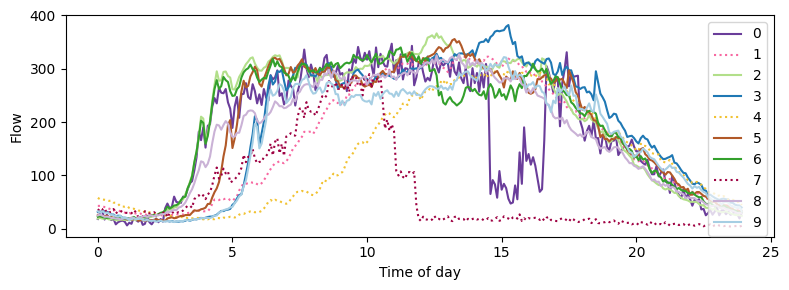

In [15]:
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.

Next, we can explore the day-type profilex

As you can see with first shot using k-means we can much more day-type patterns as we may expect, it even enable to identify potential outliers like cluster 7 or possible incident/outlier day 1

# Part 3: Independent work - clustering evaluation

Find the day-type clusterings that you consider most representative. Evaluate clustering quality using internal evaluation metrics such as Silhouette score and others. You can consider short-term prediction as an external metric that imitates how useful recognized patterns are compared to newly observed days. In an assignment, motivate why you consider the method selected by you as superior.

**NOTE** ***This part of exercise as well with all you have learned about clustering is the basis for your reflection in mandatory grated assignment for the MODULE 5***

You can use above and below scripts for experimenting with different methods, metrics and number of clusters

## Internal evaluation

Below is just example for using internal metrics in scikit-learn

In [16]:

# Import relevant metrics from scikit-learn
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

# Calculate the Silhouette Score
SC_score = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
# Silhouette Score measures the quality of clusters, higher values indicate better separation.

# Calculate the Davies-Bouldin Score
DB_score = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
# Davies-Bouldin Score measures the average similarity between each cluster and its most similar cluster, lower values indicate better separation.

# Calculate the Calinski-Harabasz Score
CH_score = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
# Calinski-Harabasz Score measures the ratio of between-cluster variance to within-cluster variance, higher values indicate better separation.

# Print the computed cluster quality scores
print('Silhouette Score:', SC_score)
print('Davies-Bouldin Score:', DB_score)
print('Calinski-Harabasz Score:', CH_score)

Silhouette Score: 0.2079327185799874
Davies-Bouldin Score: 1.6103908384543952
Calinski-Harabasz Score: 77.64690554356817


## External evaluation with short-term prediction

First, lets load the evaluation dataset used of evaluating short-term prediction accuracy, vectorize it to day vectors and remove missing values.

In [17]:
# Read the evaluation dataset from a CSV file
data_eval_df = pd.read_csv("/content/drive/MyDrive/evaluation_dataset_exercise_5_clustering_highway_traffic.csv", sep=";")

# Sort the evaluation DataFrame by columns "Date" and "Interval_5"
data_eval_df.sort_values(["Date", "Interval_5"])

# Extract unique dates from the sorted evaluation DataFrame
days_eval = np.unique(data_eval_df[['Date']].values.ravel())
# Calculate the total number of unique days in the evaluation dataset
ndays_eval = len(days_eval)

# Group the evaluation DataFrame by the "Date" column
day_eval_subsets_df = data_eval_df.groupby(["Date"])

# Initialize a matrix 'vectorized_day_dataset_eval' filled with NaN values
vectorized_day_dataset_eval = np.zeros((ndays_eval, nintvals))
vectorized_day_dataset_eval.fill(np.nan)
# This section initializes a 2D array to store the evaluation dataset and fills it with NaN values.

# Loop through each unique day in the evaluation dataset
for i in range(0, ndays_eval):
    # Get the DataFrame corresponding to the current day
    df_t = day_eval_subsets_df.get_group(days_eval[i])

    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):
        # Get the current day's DataFrame (this line is redundant)
        df_t = day_eval_subsets_df.get_group(days_eval[i])

        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset_eval'
        vectorized_day_dataset_eval[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

# Print the resulting 'vectorized_day_dataset_eval'
print(vectorized_day_dataset_eval)

[[35. 29. 32. ... 62. 66. 71.]
 [44. 44. 51. ... 30. 31. 23.]
 [21. 22. 17. ... 20. 22. 22.]
 ...
 [17. 17. 20. ... 35. 25. 27.]
 [37. 25. 30. ... 37. 36. 49.]
 [42. 28. 32. ... 45. 49. 38.]]


In [18]:
# Calculate the total number of NaN values in the evaluation dataset
print('Number of NaNs:', np.sum(np.isnan(vectorized_day_dataset_eval)))

# Calculate the rate of NaN values in the evaluation dataset
print('Rate of NaNs:', np.sum(np.isnan(vectorized_day_dataset_eval)) / (ndays_eval * nintvals))

# Calculate the number of days with missing values
nans_per_day_eval = np.sum(np.isnan(vectorized_day_dataset_eval), 1)
print('Number of days with missing values:', np.size(np.where(nans_per_day_eval > 0)))

# Filter out days with no missing values and create a new dataset
vectorized_day_dataset_no_nans_eval = vectorized_day_dataset_eval[np.where(nans_per_day_eval == 0)[0], :]
days_not_nans_eval = days_eval[np.where(nans_per_day_eval == 0)[0]]

# Calculate the final number of days in the evaluation dataset after removing missing values
print('Final number of days in evaluation dataset:', len(days_not_nans_eval))

# Print the list of days in the evaluation dataset with no missing values
print('List of days without missing values:', days_not_nans_eval)

# Calculate the total number of days in the filtered evaluation dataset
ndays_eval_not_nans = len(days_not_nans_eval)

Number of NaNs: 96
Rate of NaNs: 0.004166666666666667
Number of days with missing values: 11
Final number of days in evaluation dataset: 69
List of days without missing values: [20220108 20220109 20220131 20220204 20220209 20220210 20220211 20220223
 20220226 20220227 20220302 20220304 20220305 20220306 20220310 20220314
 20220315 20220321 20220323 20220326 20220403 20220406 20220416 20220418
 20220421 20220422 20220425 20220427 20220428 20220503 20220505 20220514
 20220519 20220521 20220522 20220526 20220530 20220601 20220603 20220609
 20220616 20220619 20220623 20220628 20220704 20220711 20220712 20220904
 20220910 20220911 20220920 20220921 20220925 20220927 20220929 20220930
 20221005 20221022 20221024 20221114 20221116 20221121 20221122 20221213
 20221216 20221218 20221220 20221223 20221230]


Now when the dataset for evaluation is ready, below is a script for evaluating short-term prediction performance.

Prediction works like this for each day at current interval *j*; we use 5 last past intervals to find the closest centroid. This average centroid is used as the source of the prediction for future time interval *j+1*. This directly measures how the representative pattern matches the new future days not part of your training and thus evaluates the clustering to external data and not as internal metrics.

In [19]:
# Import the pairwise_distances function from scikit-learn's metrics library
import sklearn.metrics.pairwise as dis_lib

# Define a function to find the closest centroid to a new data point within a specified day-time interval range
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    # Iterate through each centroid
    for i in range(0, len(centroids)):
        # Calculate the Euclidean distance between the centroid and the new data point
        ed_t = dis_lib.paired_distances(centroids[i], new_day, metric='euclidean')

        # Check if the current centroid is closer than the previously closest one
        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid

# Initialize a list to store centroid data
centroids = []

# Calculate centroids for each cluster
for i in range(0, n_clusters_t):
    centroid = np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).reshape(1, nintvals)
    centroids.append(centroid)

# Define the number of past intervals to consider for classification
n_past_intervals_for_classification = 5

# Initialize variables to calculate accuracy metrics
total_mae = 0
total_mape = 0
prediction_counts = 0

# Loop through each day in the evaluation dataset with no missing values
for i in range(0, ndays_eval_not_nans):
    # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
    for j in range(n_past_intervals_for_classification, nintvals - 1):
        # Find the closest centroid for the current data point
        centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)

        # Predict the value for the next interval
        predicted_value = centroids[centroid_index][0, j + 1]

        # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
        mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
        mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])

        # Accumulate MAE, MAPE, and count of predictions
        total_mae += mae_t
        total_mape += mape_t
        prediction_counts += 1

# Calculate and print the prediction accuracy metrics
print('Prediction accuracy MAE:', total_mae / prediction_counts)
print('Prediction accuracy MAPE:', total_mape / prediction_counts)


Prediction accuracy MAE: 24.884207359393486
Prediction accuracy MAPE: 0.24574580602006896


## Assignment

### KMeans

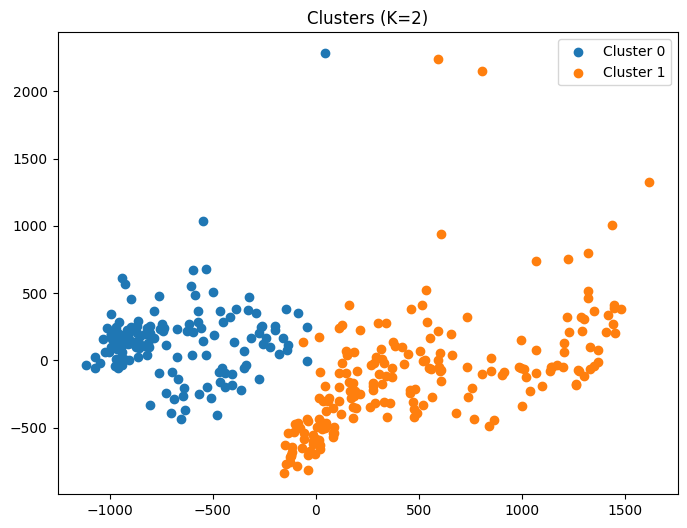

Cluster Labels (K=2): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0
 0 1 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0
 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1
 1 1 1 1]


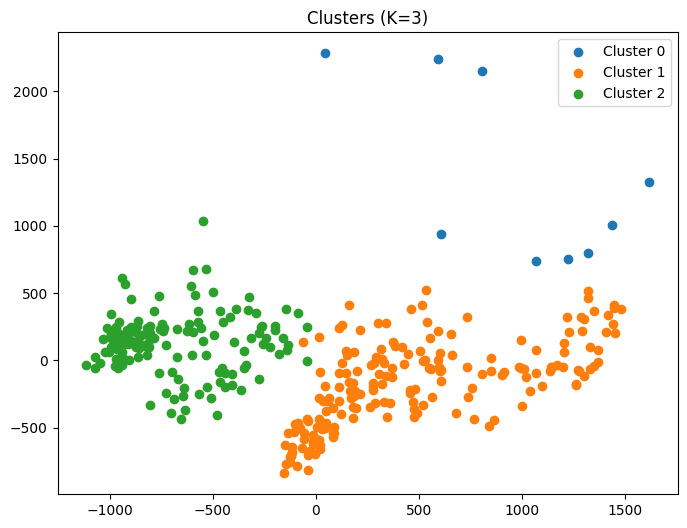

Cluster Labels (K=3): [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 1 1 2 2 2 1 2 1 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 2 1 1
 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 0 0 1 2 2 2 2 2 1 0 2 2 2 1 1 2 2 2 2
 2 1 1 2 2 2 2 2 1 1 2 1 1 1 2 2 2 0 1 1 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2
 2 2 1 1 2 2 2 2 2 1 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2 0 2 2 2 1 1
 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2
 1 1 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 1 1 2 2 2 2 2 1 1 2 2 2 1 0 0 1 1
 1 1 1 0]


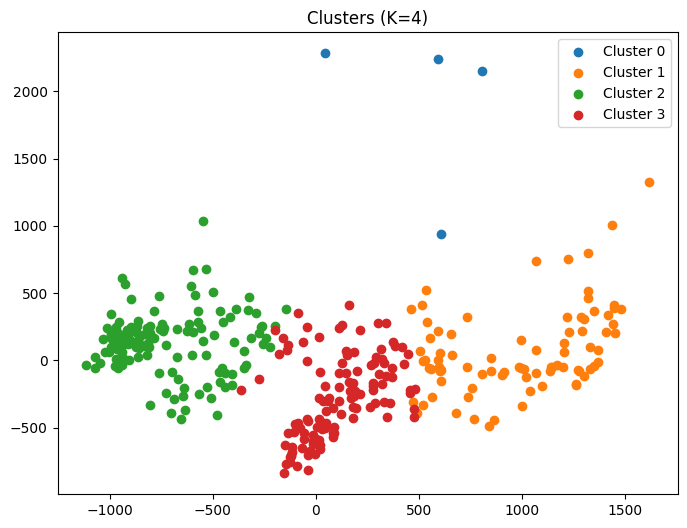

Cluster Labels (K=4): [1 1 1 3 3 1 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 1 1 3 3 3 3 3 1 1
 3 3 3 3 3 1 1 3 3 3 3 1 1 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3
 3 1 1 3 3 3 3 3 1 3 3 1 1 1 1 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3
 3 3 3 1 1 2 2 2 2 2 3 1 2 2 2 3 2 1 1 2 2 3 1 2 2 2 2 2 3 3 2 2 2 2 2 3 1
 2 2 2 2 2 3 3 2 2 2 2 2 3 1 2 2 2 2 0 1 1 2 2 2 2 2 3 0 2 2 2 1 1 2 2 2 2
 2 1 1 2 3 3 3 3 1 1 2 3 1 1 2 2 2 0 1 1 2 2 2 2 2 3 1 2 2 2 2 2 3 1 2 2 2
 2 2 3 3 2 2 2 2 2 3 2 3 1 2 2 2 2 2 3 1 2 2 2 2 3 3 2 2 2 2 2 0 2 2 2 3 3
 2 2 2 2 2 3 1 2 2 2 2 2 3 1 2 2 2 2 3 1 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2
 1 1 2 3 2 2 2 1 1 2 2 2 3 3 1 1 2 3 2 3 1 1 2 2 2 2 2 1 1 2 3 3 3 1 1 1 1
 3 3 3 1]


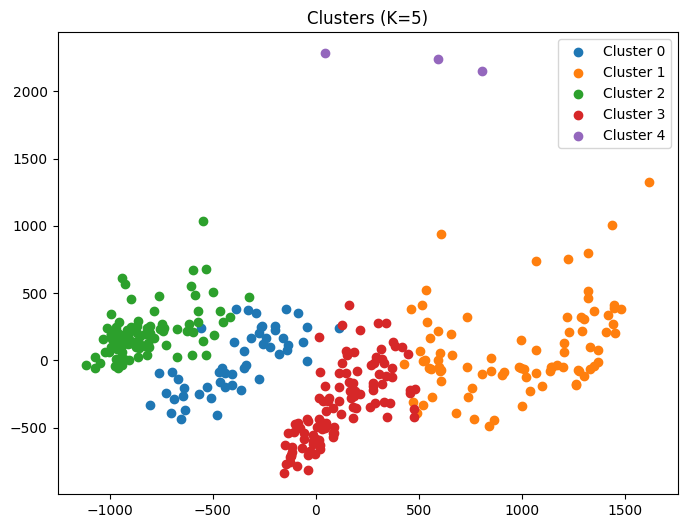

Cluster Labels (K=5): [1 1 1 3 3 1 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 1 1 3 3 3 3 3 1 1
 3 3 3 3 3 1 1 3 3 3 3 1 1 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3
 3 1 1 3 3 3 3 3 1 3 3 1 1 1 1 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3
 3 3 3 1 1 2 2 2 2 2 3 1 2 2 2 3 0 1 1 2 2 3 1 2 2 2 2 2 3 3 2 2 2 2 2 3 1
 2 2 2 2 2 3 3 2 2 2 2 2 3 1 2 2 2 2 1 1 1 2 2 2 2 2 3 4 2 2 2 1 1 0 0 0 0
 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 4 1 1 2 2 2 2 2 3 1 2 2 2 2 2 3 1 2 2 2
 2 2 3 3 2 2 2 2 2 3 2 3 1 2 2 2 2 2 3 1 2 2 2 2 3 3 2 2 2 2 2 4 2 2 2 3 3
 2 2 2 2 2 3 1 2 2 2 2 2 3 1 2 2 2 2 3 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 3 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1
 3 3 1 1]


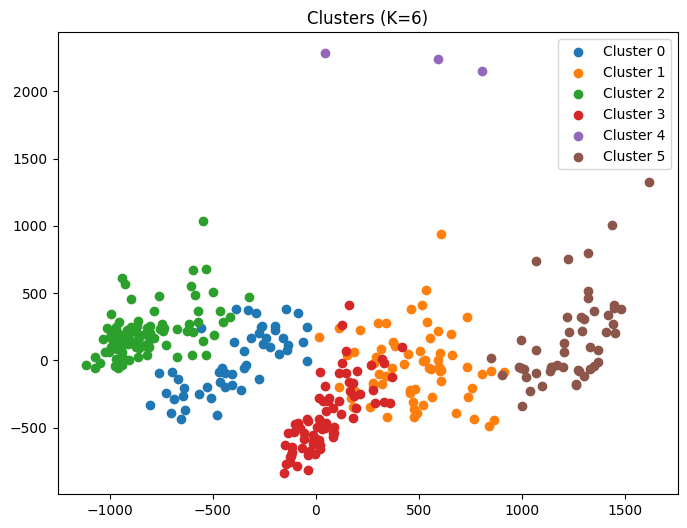

Cluster Labels (K=6): [5 5 5 1 1 5 3 3 5 5 3 3 3 3 3 5 5 3 3 3 3 3 5 5 3 3 3 3 5 5 3 1 3 3 3 5 5
 3 3 3 3 3 5 5 3 3 3 3 5 5 3 3 3 3 5 5 3 3 3 3 3 5 5 3 3 3 3 3 5 5 3 3 3 3
 3 5 5 3 3 3 3 3 5 3 3 5 5 5 5 3 3 3 3 5 5 3 3 3 3 3 5 5 3 3 3 3 3 5 5 3 3
 3 3 3 5 1 2 2 2 2 2 1 1 2 2 2 1 0 1 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 2 1 1
 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 5 1 2 2 2 2 2 1 4 2 2 2 1 1 0 0 0 0
 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 4 1 1 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2
 2 2 1 1 2 2 2 2 2 1 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2 4 2 2 2 1 1
 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 1 0 0 0 0 5 1 0 0 0 0 1 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 5 0 0 0 0 0 5 5 0 0 0 3 1 5 0 0 0 0 0 1 5 0 0 0 1 5 5 5 1
 1 1 1 5]


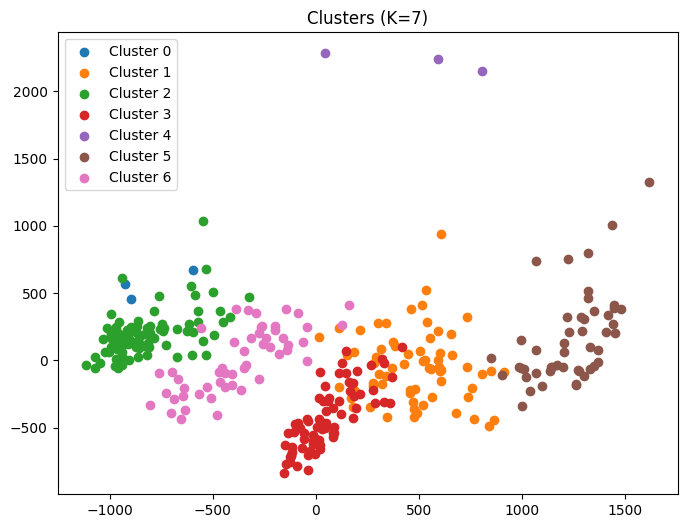

Cluster Labels (K=7): [5 5 5 1 1 5 3 3 5 5 3 3 3 3 3 5 5 3 3 3 3 3 5 5 3 3 6 3 5 5 3 1 3 3 3 5 5
 3 3 3 3 3 5 5 3 3 3 3 5 5 3 3 3 3 5 5 3 3 3 3 3 5 5 3 3 3 3 3 5 5 3 3 3 3
 3 5 5 3 3 3 3 3 5 3 3 5 5 5 5 3 3 3 3 5 5 3 3 3 3 3 5 5 3 3 3 3 3 5 5 3 3
 3 3 3 5 1 2 2 2 2 2 1 1 2 2 0 1 6 1 1 2 2 1 1 2 2 2 2 2 1 1 2 2 0 2 2 1 1
 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 5 1 2 2 2 0 2 1 4 2 2 2 1 1 6 6 6 6
 6 1 1 6 6 6 6 6 1 1 6 6 1 1 6 6 6 4 1 1 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2
 2 2 1 1 2 2 2 2 2 1 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2 4 2 2 2 1 1
 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 1 6 6 6 6 5 1 6 6 6 6 1 1 6 6 6 6 6
 1 1 6 6 6 6 6 1 5 6 6 6 6 6 5 5 6 6 6 6 1 5 6 6 6 6 6 1 5 6 6 6 1 5 5 5 1
 1 1 1 5]


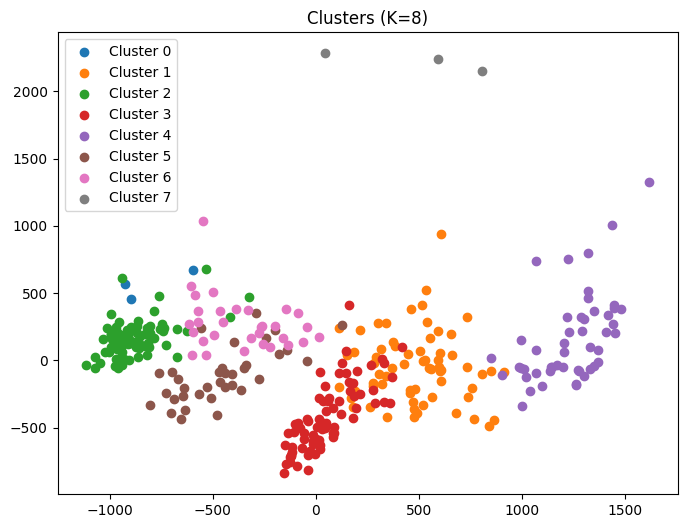

Cluster Labels (K=8): [4 4 4 1 1 4 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3 4 4 3 1 3 3 3 4 4
 3 3 3 3 3 4 4 3 3 3 3 4 4 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3
 3 4 4 3 3 3 3 3 4 3 3 4 4 4 4 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3
 3 3 3 4 1 2 2 2 2 2 1 1 2 2 0 6 6 1 1 2 2 1 1 2 2 2 2 2 1 1 2 2 0 2 2 1 1
 2 2 2 2 2 1 1 2 6 2 2 6 1 1 2 2 2 2 1 4 1 2 6 2 0 6 1 7 6 6 6 1 1 6 6 6 6
 6 1 1 6 6 6 6 6 1 1 6 6 1 1 6 6 6 7 1 1 6 6 6 6 6 1 1 2 2 2 2 2 1 1 2 2 2
 2 2 1 1 2 2 2 2 6 1 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2 7 2 2 2 1 1
 2 2 2 2 2 1 1 2 2 2 2 6 1 1 2 2 2 2 1 1 5 5 5 5 4 1 5 5 5 5 1 1 5 5 5 5 5
 1 1 5 5 5 5 5 1 4 5 5 5 5 5 4 4 5 5 5 5 1 4 5 5 5 5 5 1 4 5 5 5 1 4 4 4 1
 1 1 1 4]


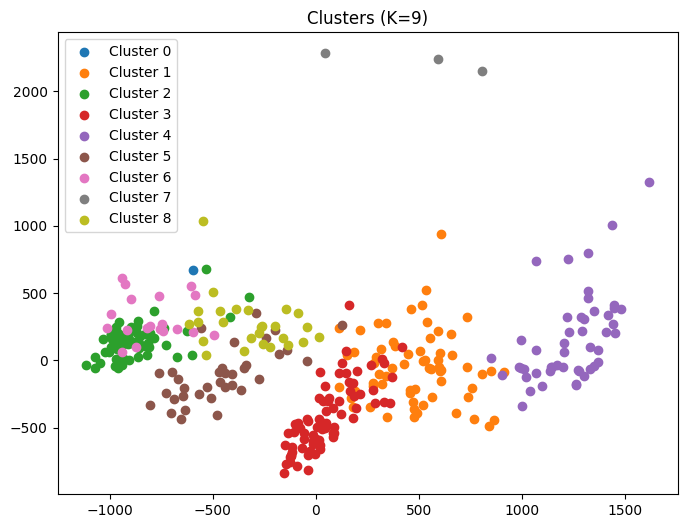

Cluster Labels (K=9): [4 4 4 1 1 4 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3 4 4 3 1 3 3 3 4 4
 3 3 3 3 3 4 4 3 3 3 3 4 4 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3
 3 4 4 3 3 3 3 3 4 3 3 4 4 4 4 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3
 3 3 3 4 1 2 2 2 2 2 1 1 2 2 6 8 8 1 1 2 2 1 1 2 2 2 2 2 1 1 2 2 6 2 6 1 1
 2 2 6 6 6 1 1 2 6 2 2 8 1 1 2 2 6 2 1 4 1 6 8 2 0 8 1 7 8 6 8 1 1 8 8 8 8
 8 1 1 8 8 8 8 8 1 1 8 8 1 1 8 8 8 7 1 1 8 8 8 2 6 1 1 2 2 2 2 6 1 1 2 2 2
 6 6 1 1 2 2 2 2 6 1 2 1 1 2 2 6 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2 7 2 2 2 1 1
 2 2 2 2 6 1 1 2 2 2 6 8 1 1 6 2 2 2 1 1 5 5 5 5 4 1 5 5 5 5 1 1 5 5 5 5 5
 1 1 5 5 5 5 5 1 4 5 5 5 5 5 4 4 5 5 5 5 1 4 5 5 5 5 5 1 4 5 5 5 1 4 4 4 1
 1 1 1 4]


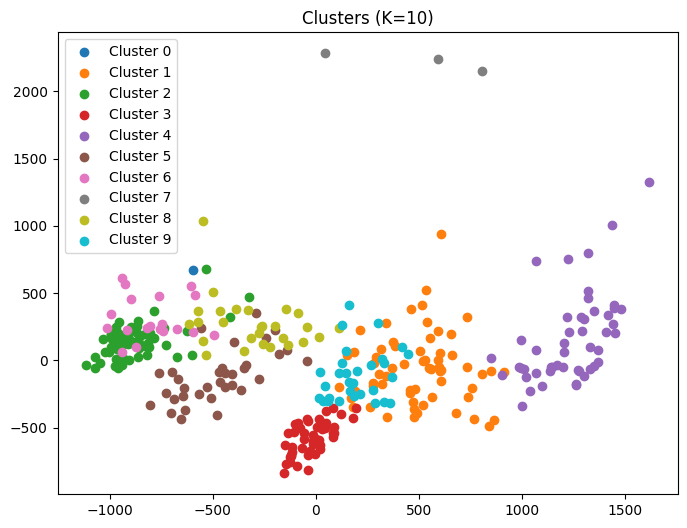

Cluster Labels (K=10): [4 4 4 9 1 4 9 9 4 4 9 9 9 9 9 4 4 9 3 3 3 3 4 4 9 9 9 9 4 4 9 9 9 9 9 4 4
 9 9 9 9 3 4 4 9 3 3 3 4 4 3 3 3 3 4 4 3 3 9 3 9 4 4 3 9 3 9 3 4 4 3 3 3 3
 3 4 4 3 3 9 3 3 4 3 3 4 4 4 4 9 3 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3
 3 3 3 4 1 2 2 2 2 2 1 1 2 2 6 8 8 1 1 2 2 1 1 2 2 2 2 2 1 1 2 2 6 2 6 1 1
 2 2 6 6 6 1 1 2 6 2 2 8 1 1 2 2 6 2 1 4 1 6 8 2 0 8 1 7 8 6 8 1 1 8 8 8 8
 8 1 1 8 8 8 8 8 1 1 8 8 1 1 8 8 8 7 1 1 8 8 8 2 6 1 1 2 2 2 2 6 1 1 2 2 2
 6 6 1 1 2 2 2 2 6 1 2 1 1 2 2 6 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2 7 2 2 2 1 1
 2 2 2 2 6 1 1 2 2 2 6 8 1 1 6 2 2 2 1 1 5 5 5 5 4 1 5 5 5 5 1 1 5 5 5 5 5
 1 1 5 5 5 5 5 1 4 5 5 5 5 5 4 4 5 5 5 9 1 4 5 5 5 5 5 1 4 5 5 5 8 4 4 4 1
 1 1 1 4]
Number of Clusters: 2
Silhouette Score: 0.30762127308637705
Davies-Bouldin Score: 1.2677249598188514
Calinski-Harabasz Score: 174.1048835493247
--------------------------------------------------
Number of Clusters: 3
Silhouette Score: 0.3005356252450667
Davies-Bouldin Score: 1.19297485489169

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

num_clusters_range = range(2, 11)
SC_scores = []
DB_scores = []
CH_scores = []

for i, n_clusters in enumerate(num_clusters_range):
    clusters = None
    vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
    days_not_nans = days[np.where(nans_per_day == 0)[0]]
    # Perform clustering
    clusters = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(vectorized_day_dataset_no_nans)

    if clusters is not None:
        cluster_labels = clusters.labels_

        # Calculate the Silhouette Score
        SC = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
        SC_scores.append(SC)

        # Calculate the Davies-Bouldin Score
        DB = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
        DB_scores.append(DB)

        # Calculate the Calinski-Harabasz Score
        CH = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
        CH_scores.append(CH)

        # Visualize clusters using PCA (2D plot)
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(vectorized_day_dataset_no_nans)

        # Create a scatter plot with cluster labels
        plt.figure(figsize=(8, 6))
        for cluster_num in range(n_clusters):
            cluster_points = reduced_data[cluster_labels == cluster_num]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_num}')

        plt.title(f'Clusters (K={n_clusters})')
        plt.legend()
        plt.show()

        # Print cluster labels for data points
        print(f'Cluster Labels (K={n_clusters}): {cluster_labels}')

# Print the computed cluster quality scores for each number of clusters
for i, n_clusters in enumerate(num_clusters_range):
    print(f'Number of Clusters: {n_clusters}')
    print('Silhouette Score:', SC_scores[i])
    print('Davies-Bouldin Score:', DB_scores[i])
    print('Calinski-Harabasz Score:', CH_scores[i])
    print('-' * 50)


### K-means Plot

In [44]:
n_clusters = 7
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

clusters = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

if clusters is not None:
  cluster_labels = clusters.labels_

#cluster_labels = GaussianMixture(n_components=n_clusters).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans) #check the parameters at  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py

# Initialize a list to store centroid data
centroids = []
n_clusters_t = len(np.unique(cluster_labels))

# Import the pairwise_distances function from scikit-learn's metrics library
import sklearn.metrics.pairwise as dis_lib

# Define a function to find the closest centroid to a new data point within a specified day-time interval range
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    # Iterate through each centroid
    for i in range(0, len(centroids)):
        # Calculate the Euclidean distance between the centroid and the new data point
        ed_t = dis_lib.paired_distances(centroids[i], new_day, metric='euclidean')

        # Check if the current centroid is closer than the previously closest one
        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid



# Calculate centroids for each cluster
for i in range(0, n_clusters_t):
    centroid = np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).reshape(1, nintvals)
    centroids.append(centroid)

# Define the number of past intervals to consider for classification
n_past_intervals_for_classification = 5

# Initialize variables to calculate accuracy metrics
total_mae = 0
total_mape = 0
prediction_counts = 0

# Loop through each day in the evaluation dataset with no missing values
for i in range(0, ndays_eval_not_nans):
    # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
    for j in range(n_past_intervals_for_classification, nintvals - 1):
        # Find the closest centroid for the current data point
        centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)

        # Predict the value for the next interval
        predicted_value = centroids[centroid_index][0, j + 1]

        # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
        mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
        mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])

        # Accumulate MAE, MAPE, and count of predictions
        total_mae += mae_t
        total_mape += mape_t
        prediction_counts += 1

# Calculate and print the prediction accuracy metrics
print('Prediction accuracy MAE:', total_mae / prediction_counts)
print('Prediction accuracy MAPE:', total_mape / prediction_counts)


Prediction accuracy MAE: 25.7095162600151
Prediction accuracy MAPE: 0.25247825345489766


cluster_id_weekdays_share [3, 10, 91, 73, 1, 6, 52]
cluster_id_weekend_share [0, 56, 0, 0, 2, 43, 0]
111


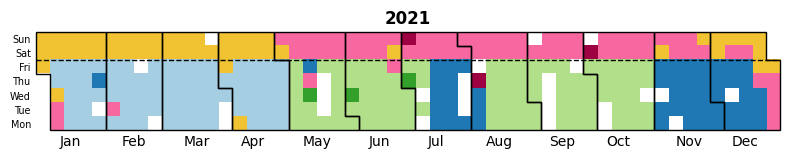

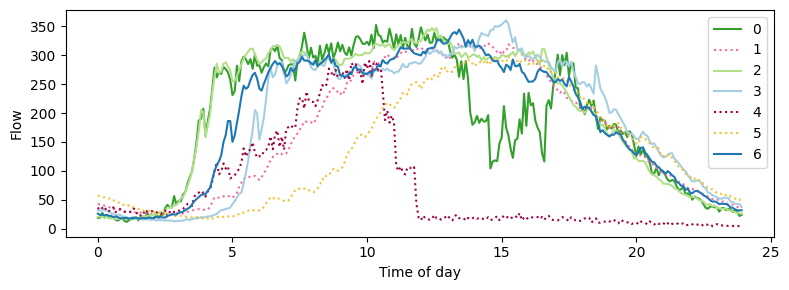

In [45]:

# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.


### AgglomerativeClustering

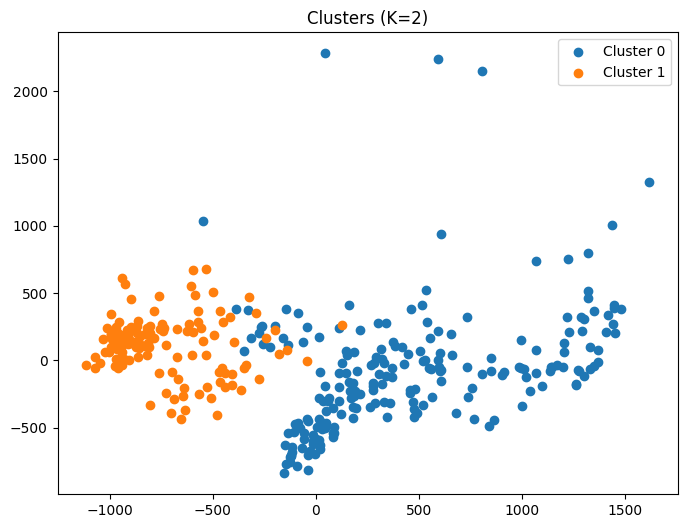

Cluster Labels (K=2): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0
 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1
 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0
 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1
 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0
 0 0 0 0]


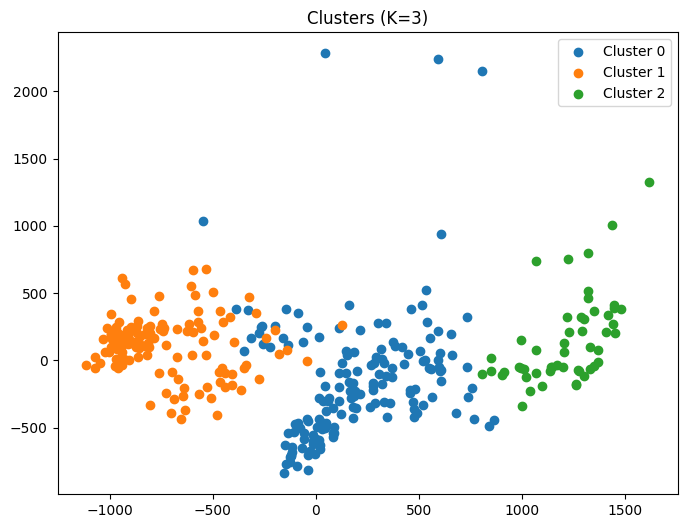

Cluster Labels (K=3): [2 2 2 0 0 2 0 0 2 2 0 0 0 0 0 2 2 0 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 0 2 2
 0 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 0 2 2 0 0 0 0 0 2 2 0 0 0 0
 0 2 2 0 0 0 0 0 2 0 0 2 2 2 2 0 0 0 0 2 2 0 0 0 0 0 2 2 0 0 0 0 0 2 2 0 0
 0 0 0 2 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0
 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 2 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1
 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0
 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 2 0 1 1 1 1 0 0 1 1 1 1 1
 0 2 1 1 1 1 1 0 2 1 1 1 1 1 2 2 1 1 1 1 2 2 1 1 1 1 1 2 2 1 1 1 0 2 2 2 0
 0 0 0 2]


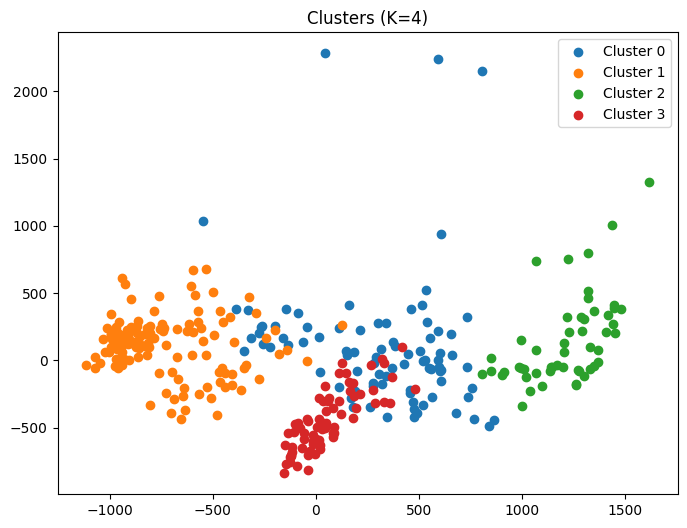

Cluster Labels (K=4): [2 2 2 0 3 2 3 3 2 2 0 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3 0 3 2 2 3 0 3 3 3 2 2
 3 3 3 3 3 2 2 3 3 3 3 2 2 3 3 3 3 2 2 3 3 3 3 0 2 2 3 3 3 0 3 2 2 3 3 3 3
 3 2 2 3 3 3 3 3 2 3 3 2 2 2 2 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3
 3 3 3 2 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0
 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 2 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1
 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0
 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 2 0 1 1 1 1 0 0 1 1 1 1 1
 0 2 1 1 1 1 1 0 2 1 1 1 1 1 2 2 1 1 1 1 2 2 1 1 1 1 1 2 2 1 1 1 0 2 2 2 0
 0 0 0 2]


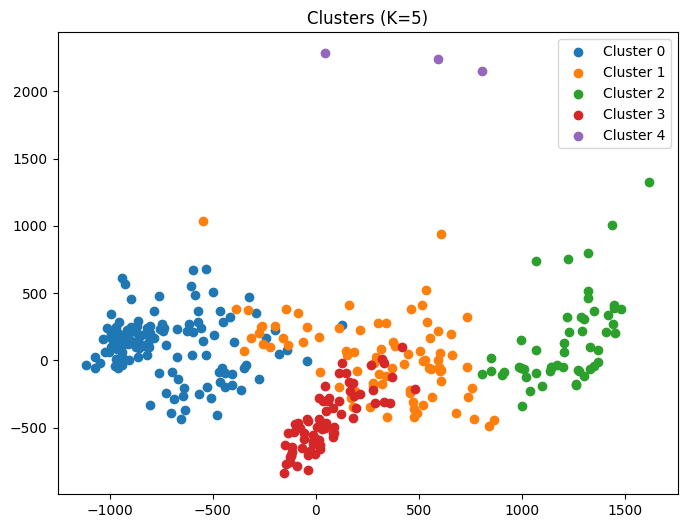

Cluster Labels (K=5): [2 2 2 1 3 2 3 3 2 2 1 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3 1 3 2 2 3 1 3 3 3 2 2
 3 3 3 3 3 2 2 3 3 3 3 2 2 3 3 3 3 2 2 3 3 3 3 1 2 2 3 3 3 1 3 2 2 3 3 3 3
 3 2 2 3 3 3 3 3 2 3 3 2 2 2 2 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3
 3 3 3 2 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 2 1 0 0 0 0 0 1 4 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0
 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 4 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 2 1 0 0 0 0 1 1 0 0 0 0 0
 1 2 0 0 0 0 0 1 2 0 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 0 2 2 0 0 0 1 2 2 2 1
 1 1 1 2]


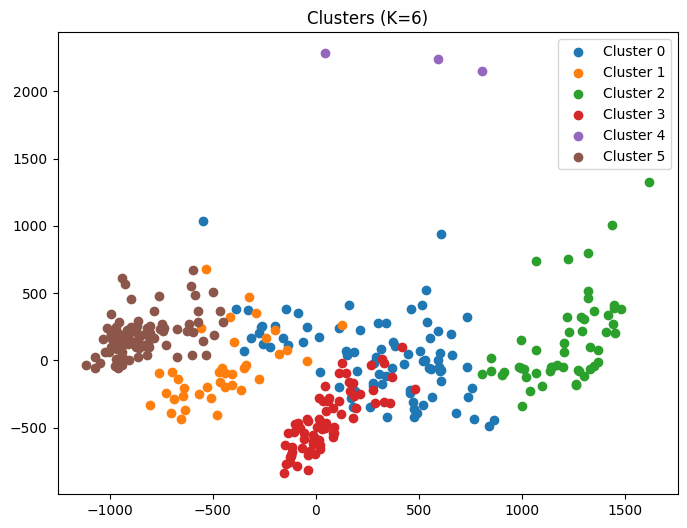

Cluster Labels (K=6): [2 2 2 0 3 2 3 3 2 2 0 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3 0 3 2 2 3 0 3 3 3 2 2
 3 3 3 3 3 2 2 3 3 3 3 2 2 3 3 3 3 2 2 3 3 3 3 0 2 2 3 3 3 0 3 2 2 3 3 3 3
 3 2 2 3 3 3 3 3 2 3 3 2 2 2 2 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3
 3 3 3 2 0 5 5 5 5 5 0 0 5 5 5 0 0 0 0 5 5 0 0 5 5 5 5 5 0 0 5 5 5 5 5 0 0
 5 5 5 5 5 0 0 5 5 5 5 5 0 0 5 5 5 5 0 2 0 5 5 5 5 5 0 4 0 5 5 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 5 5 5 5 5 0 0 5 1 5 5 5 0 0 5 5 5
 5 5 0 0 5 5 5 5 5 0 5 0 0 5 5 5 5 5 0 0 5 5 5 5 0 0 1 5 5 5 5 4 5 5 5 0 0
 5 5 5 5 5 0 0 1 5 5 5 5 0 0 5 5 5 5 0 0 1 1 1 1 2 0 1 1 1 1 0 0 1 1 1 1 1
 0 2 1 1 1 1 1 0 2 1 1 1 1 1 2 2 1 1 1 1 2 2 1 1 1 1 1 2 2 1 1 1 0 2 2 2 0
 0 0 0 2]


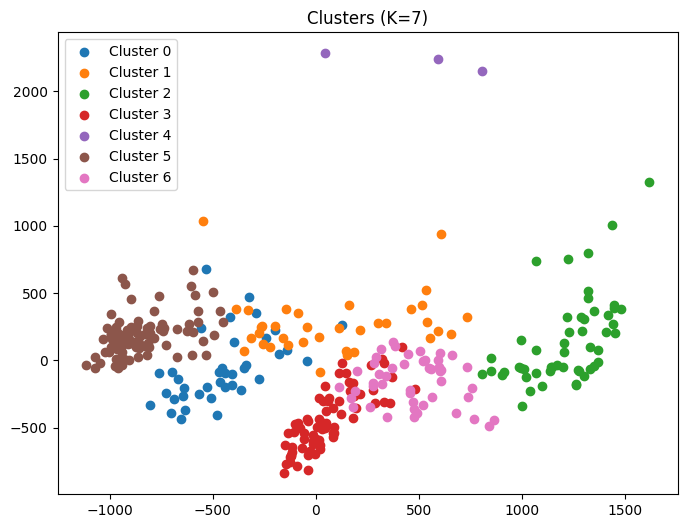

Cluster Labels (K=7): [2 2 2 6 3 2 3 3 2 2 1 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3 1 3 2 2 3 1 3 3 3 2 2
 3 3 3 3 3 2 2 3 3 3 3 2 2 3 3 3 3 2 2 3 3 3 3 6 2 2 3 3 3 1 3 2 2 3 3 3 3
 3 2 2 3 3 3 3 3 2 3 3 2 2 2 2 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3
 3 3 3 2 6 5 5 5 5 5 6 6 5 5 5 1 1 6 6 5 5 6 6 5 5 5 5 5 6 6 5 5 5 5 5 1 6
 5 5 5 5 5 6 6 5 5 5 5 5 1 6 5 5 5 5 1 2 6 5 5 5 5 5 1 4 1 5 5 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 1 4 6 6 5 5 5 5 5 6 6 5 0 5 5 5 6 6 5 5 5
 5 5 6 6 5 5 5 5 5 1 5 6 6 5 5 5 5 5 6 6 5 5 5 5 6 6 0 5 5 5 5 4 5 5 5 6 6
 5 5 5 5 5 6 6 0 5 5 5 5 6 6 5 5 5 5 6 6 0 0 0 0 2 6 0 0 0 0 6 6 0 0 0 0 0
 6 2 0 0 0 0 0 6 2 0 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 0 2 2 0 0 0 1 2 2 2 1
 6 6 6 2]


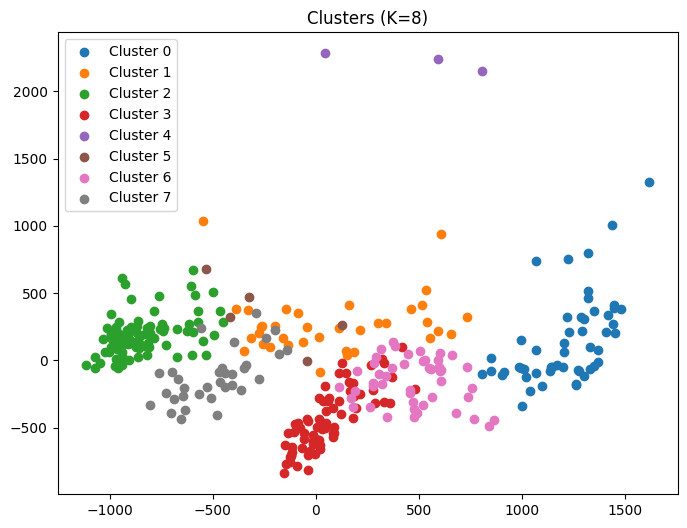

Cluster Labels (K=8): [0 0 0 6 3 0 3 3 0 0 1 3 3 3 3 0 0 3 3 3 3 3 0 0 3 3 1 3 0 0 3 1 3 3 3 0 0
 3 3 3 3 3 0 0 3 3 3 3 0 0 3 3 3 3 0 0 3 3 3 3 6 0 0 3 3 3 1 3 0 0 3 3 3 3
 3 0 0 3 3 3 3 3 0 3 3 0 0 0 0 3 3 3 3 0 0 3 3 3 3 3 0 0 3 3 3 3 3 0 0 3 3
 3 3 3 0 6 2 2 2 2 2 6 6 2 2 2 1 1 6 6 2 2 6 6 2 2 2 2 2 6 6 2 2 2 2 2 1 6
 2 2 2 2 2 6 6 2 2 2 2 2 1 6 2 2 2 2 1 0 6 2 2 2 2 2 1 4 1 2 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 1 4 6 6 2 2 2 2 2 6 6 2 5 2 2 2 6 6 2 2 2
 2 2 6 6 2 2 2 2 2 1 2 6 6 2 2 2 2 2 6 6 2 2 2 2 6 6 5 2 2 2 2 4 2 2 2 6 6
 2 2 2 2 2 6 6 5 2 2 2 2 6 6 2 2 2 2 6 6 7 7 7 7 0 6 7 7 7 7 6 6 7 7 7 7 7
 6 0 7 5 7 7 7 6 0 7 7 7 7 7 0 0 7 7 7 5 0 0 7 7 7 7 7 0 0 7 7 7 1 0 0 0 1
 6 6 6 0]


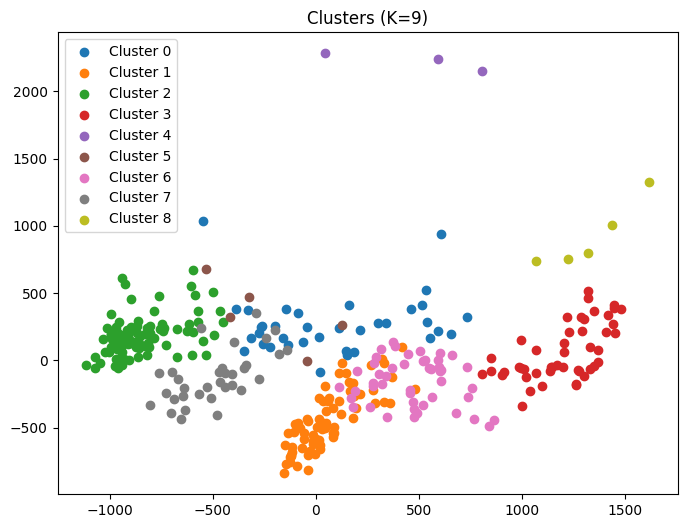

Cluster Labels (K=9): [8 3 3 6 1 3 1 1 3 3 0 1 1 1 1 3 3 1 1 1 1 1 3 3 1 1 0 1 3 3 1 0 1 1 1 3 3
 1 1 1 1 1 3 3 1 1 1 1 3 3 1 1 1 1 3 3 1 1 1 1 6 3 3 1 1 1 0 1 3 3 1 1 1 1
 1 3 3 1 1 1 1 1 3 1 1 3 3 3 3 1 1 1 1 3 3 1 1 1 1 1 3 3 1 1 1 1 1 3 3 1 1
 1 1 1 3 6 2 2 2 2 2 6 6 2 2 2 0 0 6 6 2 2 6 6 2 2 2 2 2 6 6 2 2 2 2 2 0 6
 2 2 2 2 2 6 6 2 2 2 2 2 0 6 2 2 2 2 0 8 6 2 2 2 2 2 0 4 0 2 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 4 6 6 2 2 2 2 2 6 6 2 5 2 2 2 6 6 2 2 2
 2 2 6 6 2 2 2 2 2 0 2 6 6 2 2 2 2 2 6 6 2 2 2 2 6 6 5 2 2 2 2 4 2 2 2 6 6
 2 2 2 2 2 6 6 5 2 2 2 2 6 6 2 2 2 2 6 6 7 7 7 7 3 6 7 7 7 7 6 6 7 7 7 7 7
 6 3 7 5 7 7 7 6 3 7 7 7 7 7 3 3 7 7 7 5 3 3 7 7 7 7 7 3 3 7 7 7 0 8 8 3 0
 6 6 6 8]


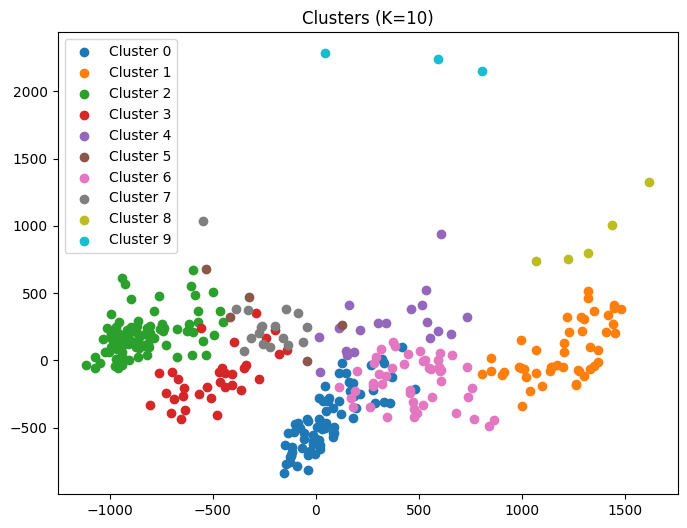

Cluster Labels (K=10): [8 1 1 6 0 1 0 0 1 1 4 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 4 0 1 1 0 4 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 6 1 1 0 0 0 4 0 1 1 0 0 0 0
 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0
 0 0 0 1 6 2 2 2 2 2 6 6 2 2 2 4 7 6 6 2 2 6 6 2 2 2 2 2 6 6 2 2 2 2 2 4 6
 2 2 2 2 2 6 6 2 2 2 2 2 4 6 2 2 2 2 4 8 6 2 2 2 2 2 4 9 7 2 2 4 4 7 7 7 7
 7 4 4 7 7 7 7 7 4 4 7 7 4 6 7 7 7 9 6 6 2 2 2 2 2 6 6 2 5 2 2 2 6 6 2 2 2
 2 2 6 6 2 2 2 2 2 4 2 6 6 2 2 2 2 2 6 6 2 2 2 2 6 6 5 2 2 2 2 9 2 2 2 6 6
 2 2 2 2 2 6 6 5 2 2 2 2 6 6 2 2 2 2 6 6 3 3 3 3 1 6 3 3 3 3 6 6 3 3 3 3 3
 6 1 3 5 3 3 3 6 1 3 3 3 3 3 1 1 3 3 3 5 1 1 3 3 3 3 3 1 1 3 3 3 4 8 8 1 4
 6 6 6 8]
Number of Clusters: 2
Silhouette Score: 0.29094541701496657
Davies-Bouldin Score: 1.279138038132245
Calinski-Harabasz Score: 159.8215045200973
--------------------------------------------------
Number of Clusters: 3
Silhouette Score: 0.26811197169820694
Davies-Bouldin Score: 1.31381148136305

In [46]:
num_clusters_range = range(2, 11)
SC_scores = []
DB_scores = []
CH_scores = []

for i, n_clusters in enumerate(num_clusters_range):
    clusters = None
    vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
    days_not_nans = days[np.where(nans_per_day == 0)[0]]
    # Perform clustering
    clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

    if clusters is not None:
        cluster_labels = clusters.labels_

        # Calculate the Silhouette Score
        SC = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
        SC_scores.append(SC)

        # Calculate the Davies-Bouldin Score
        DB = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
        DB_scores.append(DB)

        # Calculate the Calinski-Harabasz Score
        CH = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
        CH_scores.append(CH)

        # Visualize clusters using PCA (2D plot)
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(vectorized_day_dataset_no_nans)

        # Create a scatter plot with cluster labels
        plt.figure(figsize=(8, 6))
        for cluster_num in range(n_clusters):
            cluster_points = reduced_data[cluster_labels == cluster_num]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_num}')

        plt.title(f'Clusters (K={n_clusters})')
        plt.legend()
        plt.show()

        # Print cluster labels for data points
        print(f'Cluster Labels (K={n_clusters}): {cluster_labels}')

# Print the computed cluster quality scores for each number of clusters
for i, n_clusters in enumerate(num_clusters_range):
    print(f'Number of Clusters: {n_clusters}')
    print('Silhouette Score:', SC_scores[i])
    print('Davies-Bouldin Score:', DB_scores[i])
    print('Calinski-Harabasz Score:', CH_scores[i])
    print('-' * 50)

### AgglomerativeClustering Plot

In [48]:
n_clusters = 5
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(vectorized_day_dataset_no_nans)

if clusters is not None:
  cluster_labels = clusters.labels_

#cluster_labels = GaussianMixture(n_components=n_clusters).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans) #check the parameters at  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py

# Initialize a list to store centroid data
centroids = []
n_clusters_t = len(np.unique(cluster_labels))

# Import the pairwise_distances function from scikit-learn's metrics library
import sklearn.metrics.pairwise as dis_lib

# Define a function to find the closest centroid to a new data point within a specified day-time interval range
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    # Iterate through each centroid
    for i in range(0, len(centroids)):
        # Calculate the Euclidean distance between the centroid and the new data point
        ed_t = dis_lib.paired_distances(centroids[i], new_day, metric='euclidean')

        # Check if the current centroid is closer than the previously closest one
        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid


# Calculate centroids for each cluster
for i in range(0, n_clusters_t):
    centroid = np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).reshape(1, nintvals)
    centroids.append(centroid)

# Define the number of past intervals to consider for classification
n_past_intervals_for_classification = 5

# Initialize variables to calculate accuracy metrics
total_mae = 0
total_mape = 0
prediction_counts = 0

# Loop through each day in the evaluation dataset with no missing values
for i in range(0, ndays_eval_not_nans):
    # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
    for j in range(n_past_intervals_for_classification, nintvals - 1):
        # Find the closest centroid for the current data point
        centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)

        # Predict the value for the next interval
        predicted_value = centroids[centroid_index][0, j + 1]

        # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
        mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
        mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])

        # Accumulate MAE, MAPE, and count of predictions
        total_mae += mae_t
        total_mape += mape_t
        prediction_counts += 1

# Calculate and print the prediction accuracy metrics
print('Prediction accuracy MAE:', total_mae / prediction_counts)
print('Prediction accuracy MAPE:', total_mape / prediction_counts)



Prediction accuracy MAE: 28.65384718437549
Prediction accuracy MAPE: 0.29082985204795475


cluster_id_weekdays_share [128, 30, 6, 71, 1]
cluster_id_weekend_share [0, 53, 46, 0, 2]
111


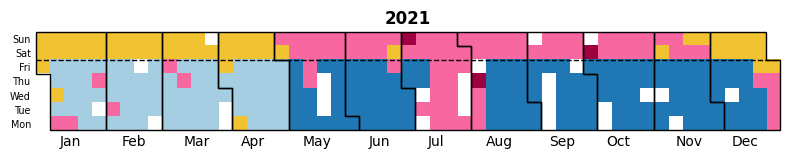

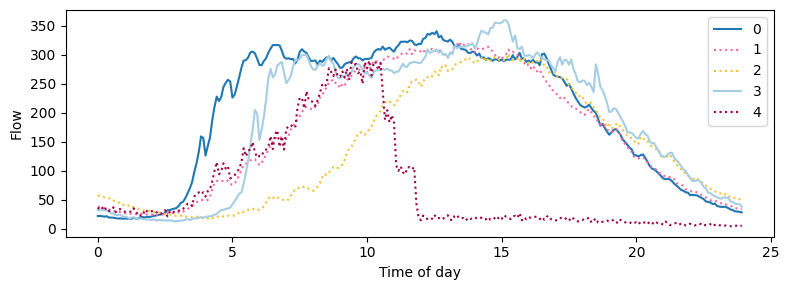

In [49]:
# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.


### DBSCAN

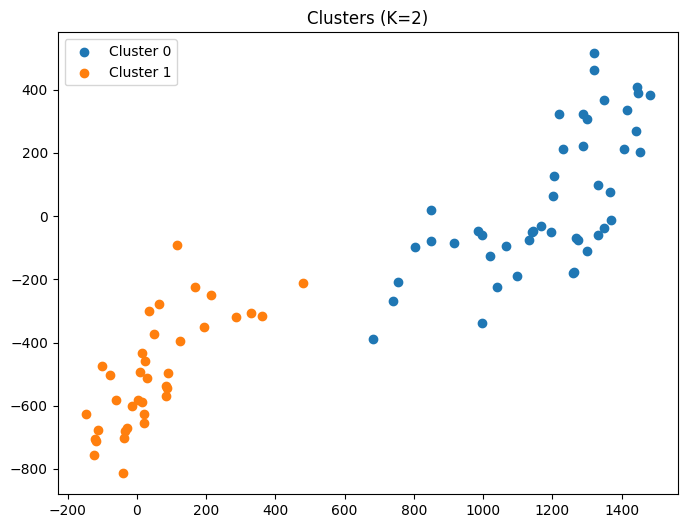

Cluster Labels (K=2): [-1  0  0 -1  1  0  1  1  0  0 -1 -1 -1 -1 -1  0  0  1 -1  1  1  1  0  0
 -1 -1 -1  1  0  0 -1 -1 -1 -1 -1  0  0  1  1  1 -1  1  0  0  1  1  1 -1
  0  0  1 -1 -1 -1  0  0  1  1 -1  1 -1  0  0  1 -1  1 -1  1  0  0  1  1
  1 -1  1  0  0  1 -1 -1 -1  1  0 -1 -1 -1  0  0  0 -1  1  1 -1  0  0 -1
  1  1 -1  1  0  0  1 -1  1  1 -1  0  0 -1  1 -1 -1 -1  0  2  3  3  3 -1
 -1  2  2 -1 -1 -1 -1  4  2  2 -1 -1  2  2 -1  3  3  3 -1  2  2 -1 -1 -1
  3 -1 -1  2  3  3 -1 -1 -1 -1  2 -1 -1  3  3 -1  2  2  3 -1 -1  3 -1 -1
  2 -1 -1 -1 -1 -1  2 -1 -1 -1  4  2  2  4  4 -1  4  4  2  2  4 -1  4  4
  4  2  2  4 -1  2  2  4 -1  4 -1  2  2 -1 -1 -1  4 -1 -1  2  3 -1 -1 -1
 -1  2 -1 -1  3 -1 -1 -1 -1  2  3  3  3 -1 -1 -1  3  2  2  3  3 -1  3 -1
  2  2  3  3 -1 -1 -1  2 -1 -1  3 -1 -1 -1 -1 -1  3 -1 -1 -1 -1  3  3 -1
 -1 -1 -1  3  3 -1 -1  2 -1 -1 -1  3  3  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1  0 -1  5 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1  0  0  5  5 -1 -

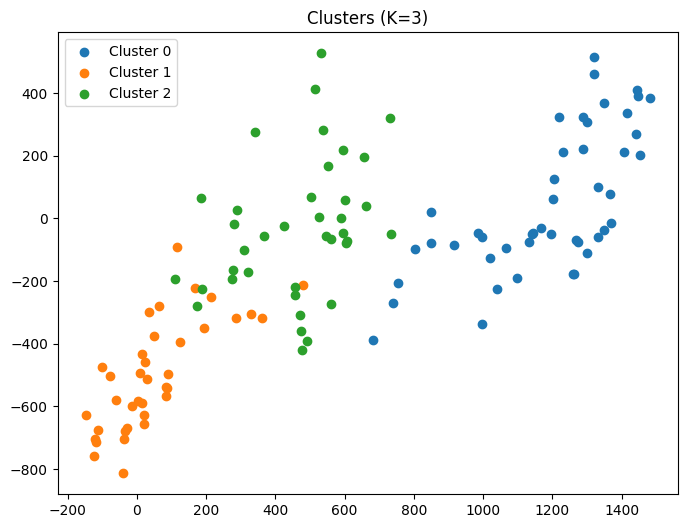

Cluster Labels (K=3): [-1  0  0 -1  1  0  1  1  0  0 -1 -1 -1 -1 -1  0  0  1 -1  1  1  1  0  0
 -1 -1 -1  1  0  0 -1 -1 -1 -1 -1  0  0  1  1  1 -1  1  0  0  1  1  1 -1
  0  0  1 -1 -1 -1  0  0  1  1 -1  1 -1  0  0  1 -1  1 -1  1  0  0  1  1
  1 -1  1  0  0  1 -1 -1 -1  1  0 -1 -1 -1  0  0  0 -1  1  1 -1  0  0 -1
  1  1 -1  1  0  0  1 -1  1  1 -1  0  0 -1  1 -1 -1 -1  0  2  3  3  3 -1
 -1  2  2 -1 -1 -1 -1  4  2  2 -1 -1  2  2 -1  3  3  3 -1  2  2 -1 -1 -1
  3 -1 -1  2  3  3 -1 -1 -1 -1  2 -1 -1  3  3 -1  2  2  3 -1 -1  3 -1 -1
  2 -1 -1 -1 -1 -1  2 -1 -1 -1  4  2  2  4  4 -1  4  4  2  2  4 -1  4  4
  4  2  2  4 -1  2  2  4 -1  4 -1  2  2 -1 -1 -1  4 -1 -1  2  3 -1 -1 -1
 -1  2 -1 -1  3 -1 -1 -1 -1  2  3  3  3 -1 -1 -1  3  2  2  3  3 -1  3 -1
  2  2  3  3 -1 -1 -1  2 -1 -1  3 -1 -1 -1 -1 -1  3 -1 -1 -1 -1  3  3 -1
 -1 -1 -1  3  3 -1 -1  2 -1 -1 -1  3  3  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1  0 -1  5 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1  0  0  5  5 -1 -

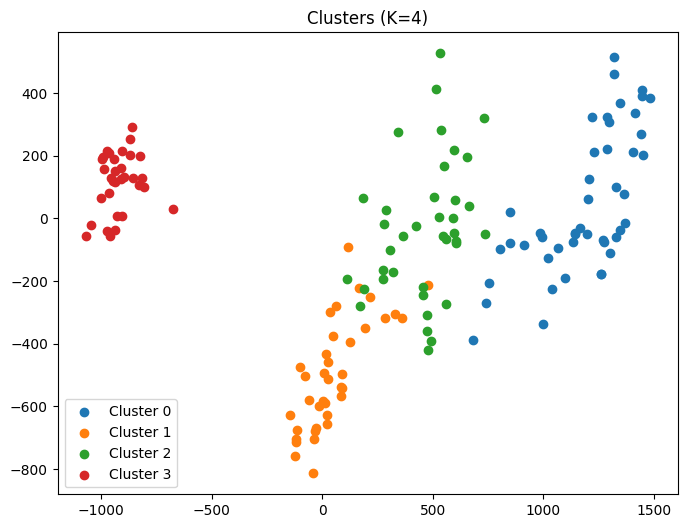

Cluster Labels (K=4): [-1  0  0 -1  1  0  1  1  0  0 -1 -1 -1 -1 -1  0  0  1 -1  1  1  1  0  0
 -1 -1 -1  1  0  0 -1 -1 -1 -1 -1  0  0  1  1  1 -1  1  0  0  1  1  1 -1
  0  0  1 -1 -1 -1  0  0  1  1 -1  1 -1  0  0  1 -1  1 -1  1  0  0  1  1
  1 -1  1  0  0  1 -1 -1 -1  1  0 -1 -1 -1  0  0  0 -1  1  1 -1  0  0 -1
  1  1 -1  1  0  0  1 -1  1  1 -1  0  0 -1  1 -1 -1 -1  0  2  3  3  3 -1
 -1  2  2 -1 -1 -1 -1  4  2  2 -1 -1  2  2 -1  3  3  3 -1  2  2 -1 -1 -1
  3 -1 -1  2  3  3 -1 -1 -1 -1  2 -1 -1  3  3 -1  2  2  3 -1 -1  3 -1 -1
  2 -1 -1 -1 -1 -1  2 -1 -1 -1  4  2  2  4  4 -1  4  4  2  2  4 -1  4  4
  4  2  2  4 -1  2  2  4 -1  4 -1  2  2 -1 -1 -1  4 -1 -1  2  3 -1 -1 -1
 -1  2 -1 -1  3 -1 -1 -1 -1  2  3  3  3 -1 -1 -1  3  2  2  3  3 -1  3 -1
  2  2  3  3 -1 -1 -1  2 -1 -1  3 -1 -1 -1 -1 -1  3 -1 -1 -1 -1  3  3 -1
 -1 -1 -1  3  3 -1 -1  2 -1 -1 -1  3  3  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1  0 -1  5 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1  0  0  5  5 -1 -

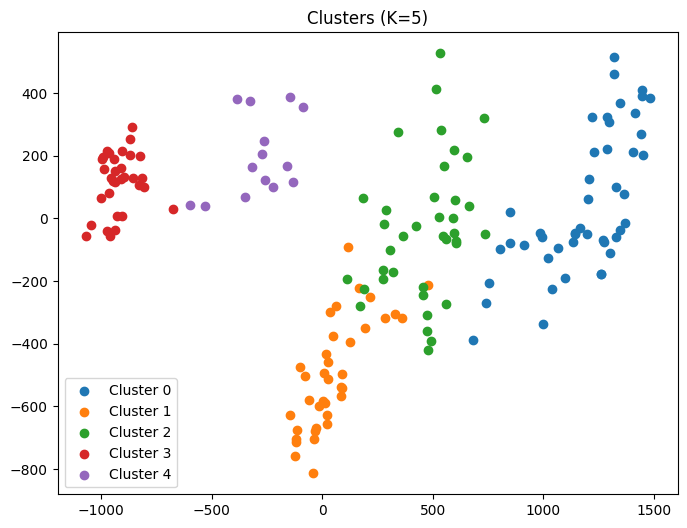

Cluster Labels (K=5): [-1  0  0 -1  1  0  1  1  0  0 -1 -1 -1 -1 -1  0  0  1 -1  1  1  1  0  0
 -1 -1 -1  1  0  0 -1 -1 -1 -1 -1  0  0  1  1  1 -1  1  0  0  1  1  1 -1
  0  0  1 -1 -1 -1  0  0  1  1 -1  1 -1  0  0  1 -1  1 -1  1  0  0  1  1
  1 -1  1  0  0  1 -1 -1 -1  1  0 -1 -1 -1  0  0  0 -1  1  1 -1  0  0 -1
  1  1 -1  1  0  0  1 -1  1  1 -1  0  0 -1  1 -1 -1 -1  0  2  3  3  3 -1
 -1  2  2 -1 -1 -1 -1  4  2  2 -1 -1  2  2 -1  3  3  3 -1  2  2 -1 -1 -1
  3 -1 -1  2  3  3 -1 -1 -1 -1  2 -1 -1  3  3 -1  2  2  3 -1 -1  3 -1 -1
  2 -1 -1 -1 -1 -1  2 -1 -1 -1  4  2  2  4  4 -1  4  4  2  2  4 -1  4  4
  4  2  2  4 -1  2  2  4 -1  4 -1  2  2 -1 -1 -1  4 -1 -1  2  3 -1 -1 -1
 -1  2 -1 -1  3 -1 -1 -1 -1  2  3  3  3 -1 -1 -1  3  2  2  3  3 -1  3 -1
  2  2  3  3 -1 -1 -1  2 -1 -1  3 -1 -1 -1 -1 -1  3 -1 -1 -1 -1  3  3 -1
 -1 -1 -1  3  3 -1 -1  2 -1 -1 -1  3  3  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1  0 -1  5 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1  0  0  5  5 -1 -

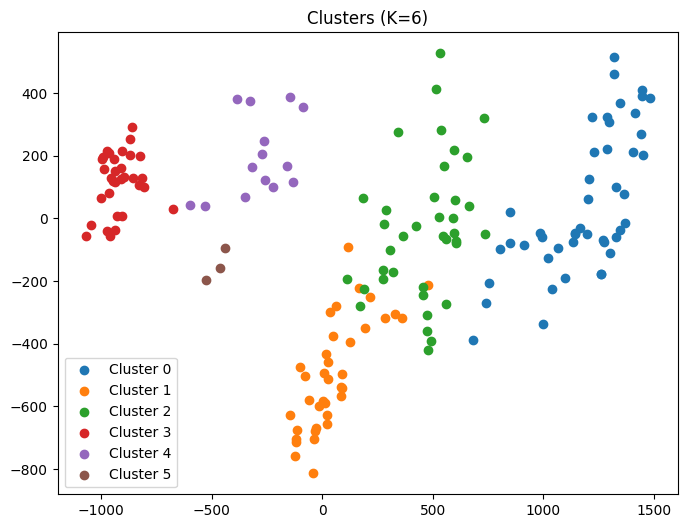

Cluster Labels (K=6): [-1  0  0 -1  1  0  1  1  0  0 -1 -1 -1 -1 -1  0  0  1 -1  1  1  1  0  0
 -1 -1 -1  1  0  0 -1 -1 -1 -1 -1  0  0  1  1  1 -1  1  0  0  1  1  1 -1
  0  0  1 -1 -1 -1  0  0  1  1 -1  1 -1  0  0  1 -1  1 -1  1  0  0  1  1
  1 -1  1  0  0  1 -1 -1 -1  1  0 -1 -1 -1  0  0  0 -1  1  1 -1  0  0 -1
  1  1 -1  1  0  0  1 -1  1  1 -1  0  0 -1  1 -1 -1 -1  0  2  3  3  3 -1
 -1  2  2 -1 -1 -1 -1  4  2  2 -1 -1  2  2 -1  3  3  3 -1  2  2 -1 -1 -1
  3 -1 -1  2  3  3 -1 -1 -1 -1  2 -1 -1  3  3 -1  2  2  3 -1 -1  3 -1 -1
  2 -1 -1 -1 -1 -1  2 -1 -1 -1  4  2  2  4  4 -1  4  4  2  2  4 -1  4  4
  4  2  2  4 -1  2  2  4 -1  4 -1  2  2 -1 -1 -1  4 -1 -1  2  3 -1 -1 -1
 -1  2 -1 -1  3 -1 -1 -1 -1  2  3  3  3 -1 -1 -1  3  2  2  3  3 -1  3 -1
  2  2  3  3 -1 -1 -1  2 -1 -1  3 -1 -1 -1 -1 -1  3 -1 -1 -1 -1  3  3 -1
 -1 -1 -1  3  3 -1 -1  2 -1 -1 -1  3  3  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1  0 -1  5 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1  0  0  5  5 -1 -

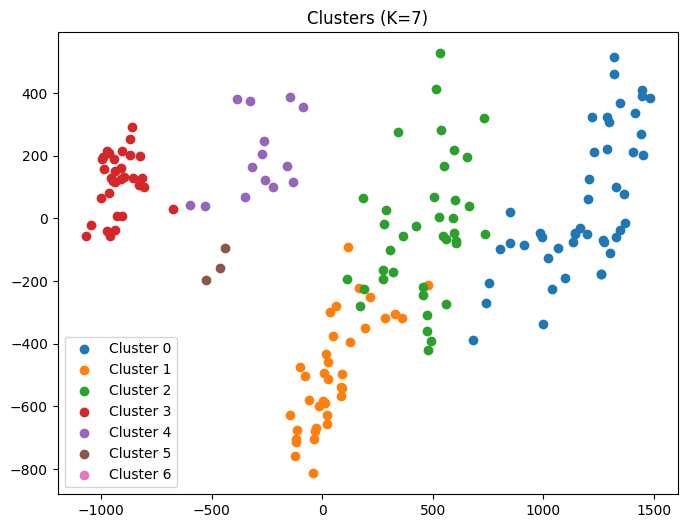

Cluster Labels (K=7): [-1  0  0 -1  1  0  1  1  0  0 -1 -1 -1 -1 -1  0  0  1 -1  1  1  1  0  0
 -1 -1 -1  1  0  0 -1 -1 -1 -1 -1  0  0  1  1  1 -1  1  0  0  1  1  1 -1
  0  0  1 -1 -1 -1  0  0  1  1 -1  1 -1  0  0  1 -1  1 -1  1  0  0  1  1
  1 -1  1  0  0  1 -1 -1 -1  1  0 -1 -1 -1  0  0  0 -1  1  1 -1  0  0 -1
  1  1 -1  1  0  0  1 -1  1  1 -1  0  0 -1  1 -1 -1 -1  0  2  3  3  3 -1
 -1  2  2 -1 -1 -1 -1  4  2  2 -1 -1  2  2 -1  3  3  3 -1  2  2 -1 -1 -1
  3 -1 -1  2  3  3 -1 -1 -1 -1  2 -1 -1  3  3 -1  2  2  3 -1 -1  3 -1 -1
  2 -1 -1 -1 -1 -1  2 -1 -1 -1  4  2  2  4  4 -1  4  4  2  2  4 -1  4  4
  4  2  2  4 -1  2  2  4 -1  4 -1  2  2 -1 -1 -1  4 -1 -1  2  3 -1 -1 -1
 -1  2 -1 -1  3 -1 -1 -1 -1  2  3  3  3 -1 -1 -1  3  2  2  3  3 -1  3 -1
  2  2  3  3 -1 -1 -1  2 -1 -1  3 -1 -1 -1 -1 -1  3 -1 -1 -1 -1  3  3 -1
 -1 -1 -1  3  3 -1 -1  2 -1 -1 -1  3  3  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1  0 -1  5 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1  0  0  5  5 -1 -

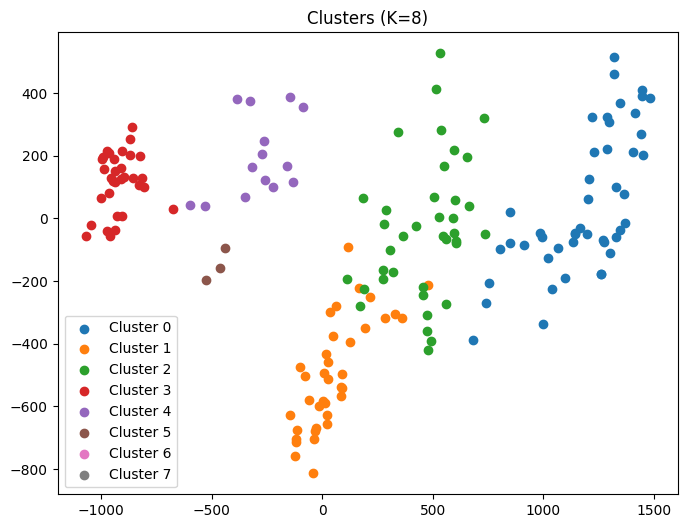

Cluster Labels (K=8): [-1  0  0 -1  1  0  1  1  0  0 -1 -1 -1 -1 -1  0  0  1 -1  1  1  1  0  0
 -1 -1 -1  1  0  0 -1 -1 -1 -1 -1  0  0  1  1  1 -1  1  0  0  1  1  1 -1
  0  0  1 -1 -1 -1  0  0  1  1 -1  1 -1  0  0  1 -1  1 -1  1  0  0  1  1
  1 -1  1  0  0  1 -1 -1 -1  1  0 -1 -1 -1  0  0  0 -1  1  1 -1  0  0 -1
  1  1 -1  1  0  0  1 -1  1  1 -1  0  0 -1  1 -1 -1 -1  0  2  3  3  3 -1
 -1  2  2 -1 -1 -1 -1  4  2  2 -1 -1  2  2 -1  3  3  3 -1  2  2 -1 -1 -1
  3 -1 -1  2  3  3 -1 -1 -1 -1  2 -1 -1  3  3 -1  2  2  3 -1 -1  3 -1 -1
  2 -1 -1 -1 -1 -1  2 -1 -1 -1  4  2  2  4  4 -1  4  4  2  2  4 -1  4  4
  4  2  2  4 -1  2  2  4 -1  4 -1  2  2 -1 -1 -1  4 -1 -1  2  3 -1 -1 -1
 -1  2 -1 -1  3 -1 -1 -1 -1  2  3  3  3 -1 -1 -1  3  2  2  3  3 -1  3 -1
  2  2  3  3 -1 -1 -1  2 -1 -1  3 -1 -1 -1 -1 -1  3 -1 -1 -1 -1  3  3 -1
 -1 -1 -1  3  3 -1 -1  2 -1 -1 -1  3  3  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1  0 -1  5 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1  0  0  5  5 -1 -

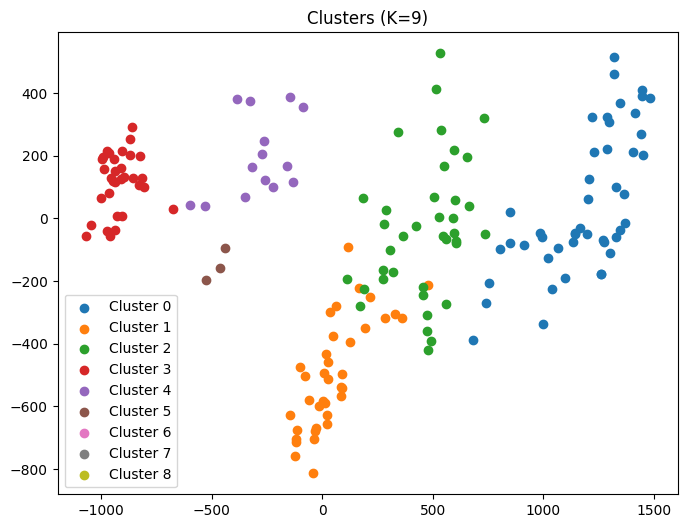

Cluster Labels (K=9): [-1  0  0 -1  1  0  1  1  0  0 -1 -1 -1 -1 -1  0  0  1 -1  1  1  1  0  0
 -1 -1 -1  1  0  0 -1 -1 -1 -1 -1  0  0  1  1  1 -1  1  0  0  1  1  1 -1
  0  0  1 -1 -1 -1  0  0  1  1 -1  1 -1  0  0  1 -1  1 -1  1  0  0  1  1
  1 -1  1  0  0  1 -1 -1 -1  1  0 -1 -1 -1  0  0  0 -1  1  1 -1  0  0 -1
  1  1 -1  1  0  0  1 -1  1  1 -1  0  0 -1  1 -1 -1 -1  0  2  3  3  3 -1
 -1  2  2 -1 -1 -1 -1  4  2  2 -1 -1  2  2 -1  3  3  3 -1  2  2 -1 -1 -1
  3 -1 -1  2  3  3 -1 -1 -1 -1  2 -1 -1  3  3 -1  2  2  3 -1 -1  3 -1 -1
  2 -1 -1 -1 -1 -1  2 -1 -1 -1  4  2  2  4  4 -1  4  4  2  2  4 -1  4  4
  4  2  2  4 -1  2  2  4 -1  4 -1  2  2 -1 -1 -1  4 -1 -1  2  3 -1 -1 -1
 -1  2 -1 -1  3 -1 -1 -1 -1  2  3  3  3 -1 -1 -1  3  2  2  3  3 -1  3 -1
  2  2  3  3 -1 -1 -1  2 -1 -1  3 -1 -1 -1 -1 -1  3 -1 -1 -1 -1  3  3 -1
 -1 -1 -1  3  3 -1 -1  2 -1 -1 -1  3  3  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1  0 -1  5 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1  0  0  5  5 -1 -

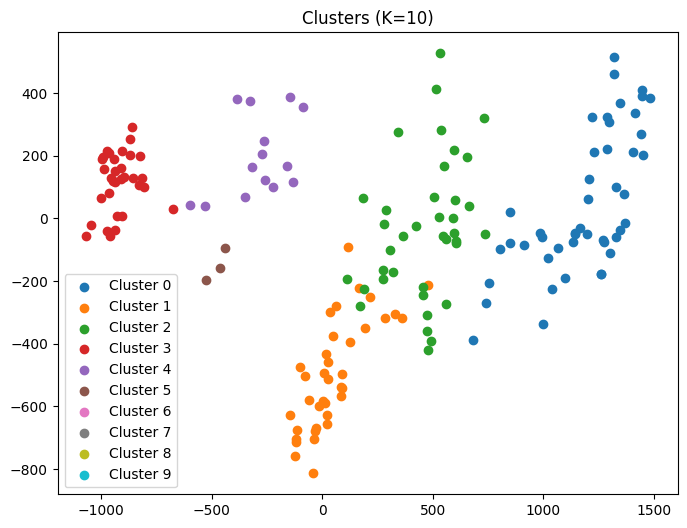

Cluster Labels (K=10): [-1  0  0 -1  1  0  1  1  0  0 -1 -1 -1 -1 -1  0  0  1 -1  1  1  1  0  0
 -1 -1 -1  1  0  0 -1 -1 -1 -1 -1  0  0  1  1  1 -1  1  0  0  1  1  1 -1
  0  0  1 -1 -1 -1  0  0  1  1 -1  1 -1  0  0  1 -1  1 -1  1  0  0  1  1
  1 -1  1  0  0  1 -1 -1 -1  1  0 -1 -1 -1  0  0  0 -1  1  1 -1  0  0 -1
  1  1 -1  1  0  0  1 -1  1  1 -1  0  0 -1  1 -1 -1 -1  0  2  3  3  3 -1
 -1  2  2 -1 -1 -1 -1  4  2  2 -1 -1  2  2 -1  3  3  3 -1  2  2 -1 -1 -1
  3 -1 -1  2  3  3 -1 -1 -1 -1  2 -1 -1  3  3 -1  2  2  3 -1 -1  3 -1 -1
  2 -1 -1 -1 -1 -1  2 -1 -1 -1  4  2  2  4  4 -1  4  4  2  2  4 -1  4  4
  4  2  2  4 -1  2  2  4 -1  4 -1  2  2 -1 -1 -1  4 -1 -1  2  3 -1 -1 -1
 -1  2 -1 -1  3 -1 -1 -1 -1  2  3  3  3 -1 -1 -1  3  2  2  3  3 -1  3 -1
  2  2  3  3 -1 -1 -1  2 -1 -1  3 -1 -1 -1 -1 -1  3 -1 -1 -1 -1  3  3 -1
 -1 -1 -1  3  3 -1 -1  2 -1 -1 -1  3  3  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1  0 -1  5 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1  0  0  5  5 -1 

In [50]:
num_clusters_range = range(2, 11)
SC_scores = []
DB_scores = []
CH_scores = []

for i, n_clusters in enumerate(num_clusters_range):
    clusters = None
    vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
    days_not_nans = days[np.where(nans_per_day == 0)[0]]
    # Perform clustering
    clusters = DBSCAN(eps=500, min_samples = 2).fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

    if clusters is not None:
        cluster_labels = clusters.labels_

        # Calculate the Silhouette Score
        SC = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
        SC_scores.append(SC)

        # Calculate the Davies-Bouldin Score
        DB = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
        DB_scores.append(DB)

        # Calculate the Calinski-Harabasz Score
        CH = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
        CH_scores.append(CH)

        # Visualize clusters using PCA (2D plot)
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(vectorized_day_dataset_no_nans)

        # Create a scatter plot with cluster labels
        plt.figure(figsize=(8, 6))
        for cluster_num in range(n_clusters):
            cluster_points = reduced_data[cluster_labels == cluster_num]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_num}')

        plt.title(f'Clusters (K={n_clusters})')
        plt.legend()
        plt.show()

        # Print cluster labels for data points
        print(f'Cluster Labels (K={n_clusters}): {cluster_labels}')

# Print the computed cluster quality scores for each number of clusters
for i, n_clusters in enumerate(num_clusters_range):
    print(f'Number of Clusters: {n_clusters}')
    print('Silhouette Score:', SC_scores[i])
    print('Davies-Bouldin Score:', DB_scores[i])
    print('Calinski-Harabasz Score:', CH_scores[i])
    print('-' * 50)

### DBSCAN Plot
DBSCAN does not require n_clusters. So setting 2 or 10 to the n_cluster is the same for results.

In [51]:
n_clusters = 10
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

clusters = DBSCAN(eps=500, min_samples = 2).fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

if clusters is not None:
  cluster_labels = clusters.labels_
# Import the pairwise_distances function from scikit-learn's metrics library
import sklearn.metrics.pairwise as dis_lib

# Define a function to find the closest centroid to a new data point within a specified day-time interval range
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    # Iterate through each centroid
    for i in range(0, len(centroids)):
        # Calculate the Euclidean distance between the centroid and the new data point
        ed_t = dis_lib.paired_distances(centroids[i], new_day, metric='euclidean')

        # Check if the current centroid is closer than the previously closest one
        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid

# Initialize a list to store centroid data
centroids = []

# Calculate centroids for each cluster
for i in range(0, n_clusters_t):
    centroid = np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).reshape(1, nintvals)
    centroids.append(centroid)

# Define the number of past intervals to consider for classification
n_past_intervals_for_classification = 5

# Initialize variables to calculate accuracy metrics
total_mae = 0
total_mape = 0
prediction_counts = 0

# Loop through each day in the evaluation dataset with no missing values
for i in range(0, ndays_eval_not_nans):
    # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
    for j in range(n_past_intervals_for_classification, nintvals - 1):
        # Find the closest centroid for the current data point
        centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)

        # Predict the value for the next interval
        predicted_value = centroids[centroid_index][0, j + 1]

        # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
        mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
        mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])

        # Accumulate MAE, MAPE, and count of predictions
        total_mae += mae_t
        total_mape += mape_t
        prediction_counts += 1

# Calculate and print the prediction accuracy metrics
print('Prediction accuracy MAE:', total_mae / prediction_counts)
print('Prediction accuracy MAPE:', total_mape / prediction_counts)

Prediction accuracy MAE: 28.822892616630796
Prediction accuracy MAPE: 0.3958731720468955


cluster_id_weekdays_share [2, 37, 3, 32, 14, 3, 145]
cluster_id_weekend_share [44, 0, 35, 0, 0, 0, 22]
111


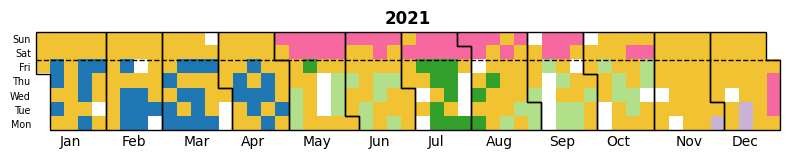

<ipython-input-52-39edfcb6d24e>:22: RuntimeWarning: Mean of empty slice
  centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())


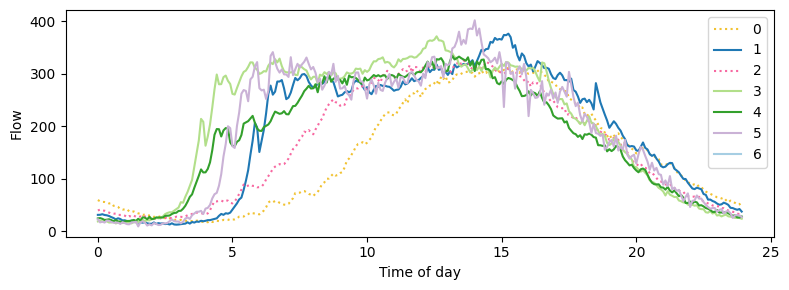

In [52]:
# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.

### GaussianMixture

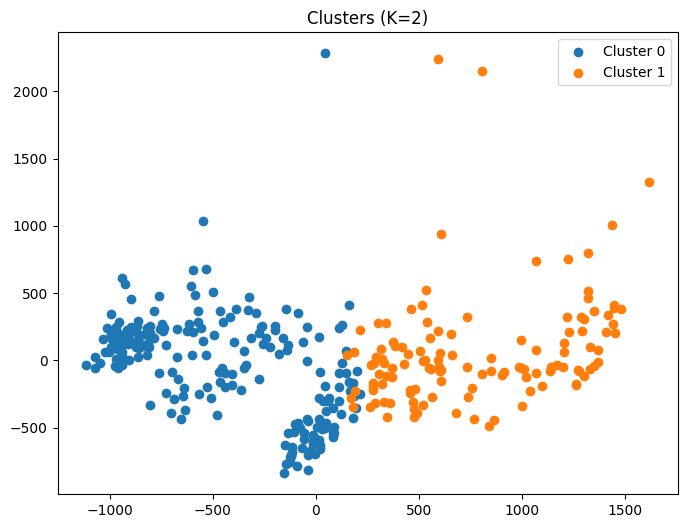

Cluster Labels (K=2): [1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1
 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0
 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0
 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0
 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0
 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1
 1 1 1 1]
Number of Clusters: 2
Silhouette Score: 0.3022832884402729
Davies-Bouldin Score: 1.2687012250940783
Calinski-Harabasz Score: 169.80547920139276
--------------------------------------------------


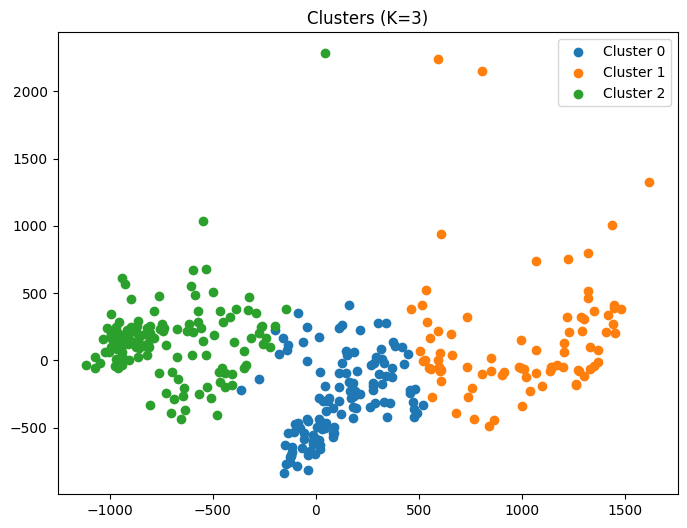

Cluster Labels (K=3): [1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0
 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0
 0 0 0 1 1 2 2 2 2 2 0 1 2 2 2 0 2 1 1 2 2 0 1 2 2 2 2 2 0 0 2 2 2 2 2 0 1
 2 2 2 2 2 0 0 2 2 2 2 2 0 1 2 2 2 2 1 1 1 2 2 2 2 2 0 1 2 2 2 1 1 2 2 2 2
 2 1 1 2 0 0 0 0 1 1 2 0 1 1 2 2 2 2 1 1 2 2 2 2 2 0 1 2 2 2 2 2 0 1 2 2 2
 2 2 0 0 2 2 2 2 2 0 2 0 0 2 2 2 2 2 0 0 2 2 2 2 0 0 2 2 2 2 2 1 2 2 2 0 0
 2 2 2 2 2 0 1 2 2 2 2 2 0 0 2 2 2 2 0 1 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2
 1 1 2 0 2 2 2 1 1 2 2 2 0 0 1 1 2 0 2 0 1 1 2 2 2 2 2 1 1 2 0 0 0 1 1 1 1
 0 0 0 1]
Number of Clusters: 3
Silhouette Score: 0.2692406087798076
Davies-Bouldin Score: 1.3587890766043185
Calinski-Harabasz Score: 159.13421302277044
--------------------------------------------------


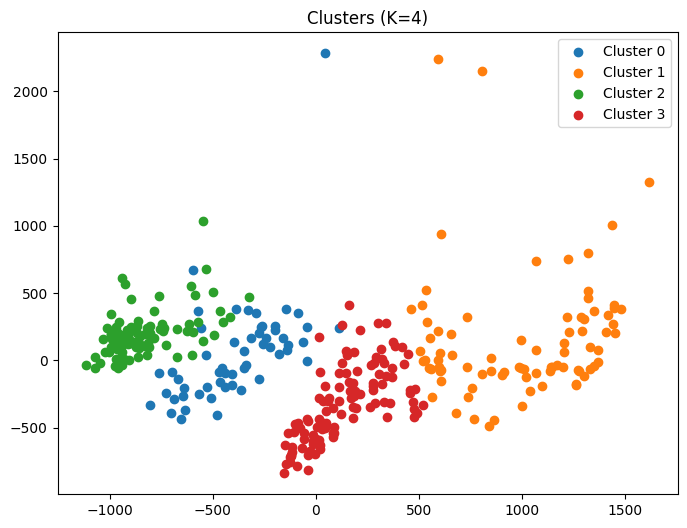

Cluster Labels (K=4): [1 1 1 3 3 1 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 1 1 3 3 3 3 3 1 1
 3 3 3 3 3 1 1 3 3 3 3 1 1 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3
 3 1 1 3 3 3 3 3 1 3 3 1 1 1 1 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3
 3 3 3 1 1 2 2 2 2 2 3 1 2 2 2 3 0 1 1 2 2 3 1 2 2 2 2 2 3 3 2 2 2 2 2 3 1
 2 2 2 2 2 3 3 2 2 2 2 2 3 1 2 2 2 2 1 1 1 2 2 2 0 0 3 1 2 2 0 1 1 0 0 0 0
 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 2 2 2 2 2 3 1 2 2 2 2 2 3 1 2 2 2
 2 2 3 3 2 2 2 2 2 3 2 3 3 2 2 2 2 2 3 3 2 2 2 2 3 3 2 2 2 2 2 1 2 2 2 3 3
 2 2 2 2 2 3 1 2 2 2 2 2 3 3 2 2 2 2 3 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 3 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1
 3 3 3 1]
Number of Clusters: 4
Silhouette Score: 0.21767109818947272
Davies-Bouldin Score: 1.7999012868166249
Calinski-Harabasz Score: 122.8082963467733
--------------------------------------------------


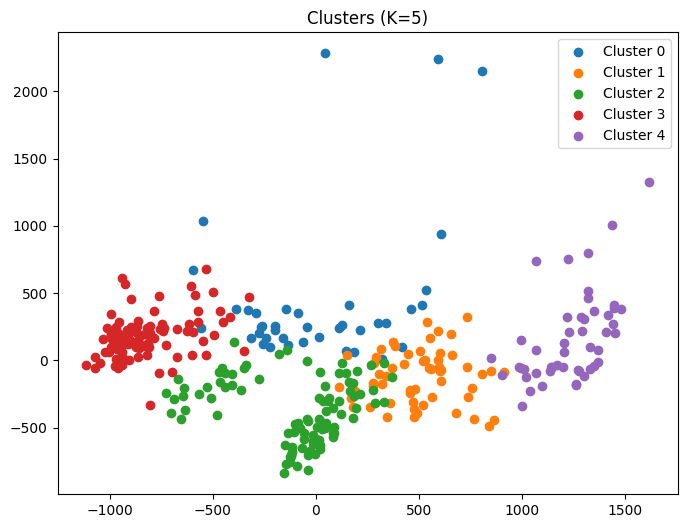

Cluster Labels (K=5): [4 4 4 1 1 4 2 1 4 4 0 2 2 0 2 4 4 2 2 2 2 2 4 4 2 2 0 2 4 4 2 0 2 2 2 4 4
 2 2 2 0 2 4 4 2 2 2 2 4 4 2 2 2 2 4 4 2 2 2 2 2 4 4 2 2 2 2 2 4 4 2 2 2 2
 2 4 4 2 2 2 2 2 4 2 2 4 4 4 4 2 2 2 2 4 4 2 2 2 2 2 4 4 2 2 2 2 2 4 4 2 2
 2 2 2 4 1 3 3 3 3 3 1 1 3 3 3 0 0 1 1 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 3 0 1
 3 3 3 3 3 1 1 3 3 3 3 3 0 1 3 3 3 3 0 4 1 3 3 3 0 3 0 0 0 3 3 1 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 1 1 3 0 0 0 1 1 3 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3
 3 3 1 1 3 3 3 3 3 1 3 1 1 3 3 3 3 3 1 1 3 3 3 3 1 1 3 3 3 3 3 0 3 3 3 1 1
 3 3 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 1 1 3 3 2 2 4 1 2 2 3 0 1 1 2 2 2 2 0
 1 1 2 2 2 2 2 1 4 2 2 2 2 2 4 4 0 0 2 0 1 4 2 2 2 2 2 1 4 2 2 2 0 4 4 4 0
 1 1 1 4]
Number of Clusters: 5
Silhouette Score: 0.2474774399133225
Davies-Bouldin Score: 1.5264623303805616
Calinski-Harabasz Score: 114.67509334079142
--------------------------------------------------


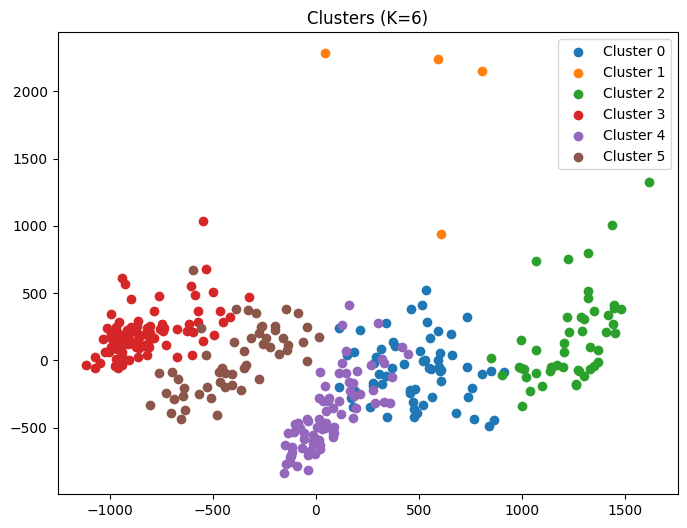

Cluster Labels (K=6): [2 2 2 4 0 2 4 4 2 2 4 4 4 4 4 2 2 4 4 4 4 4 2 2 4 4 4 4 2 2 4 4 4 4 4 2 2
 4 4 4 4 4 2 2 4 4 4 4 2 2 4 4 4 4 2 2 4 4 4 4 4 2 2 4 4 4 4 4 2 2 4 4 4 4
 4 2 2 4 4 4 4 4 2 4 4 2 2 2 2 4 4 4 4 2 2 4 4 4 4 4 2 2 4 4 4 4 4 2 2 4 4
 4 4 4 2 0 3 3 3 3 3 0 0 3 3 3 5 5 0 0 3 3 0 0 3 3 3 3 3 0 0 3 3 3 3 3 0 0
 3 3 3 3 3 0 0 3 3 3 3 3 0 0 3 3 3 3 1 2 0 3 3 3 5 3 0 1 3 3 5 0 0 5 5 5 5
 5 0 0 5 5 5 5 5 0 0 5 5 0 0 5 5 5 1 0 0 3 3 3 3 3 0 0 3 3 3 3 3 0 0 3 3 3
 3 3 0 0 3 3 3 3 3 0 3 0 0 3 3 3 3 3 0 0 3 3 3 3 0 0 3 3 3 3 3 1 3 3 3 0 0
 3 3 3 3 3 0 0 3 3 3 3 3 0 0 3 3 3 3 0 0 5 5 5 5 2 0 5 5 5 5 0 0 5 5 5 5 5
 0 0 5 5 5 5 5 0 2 5 5 5 5 5 2 2 5 5 5 4 0 2 5 5 5 5 5 0 2 5 5 5 0 2 2 2 0
 0 0 0 2]
Number of Clusters: 6
Silhouette Score: 0.23571691240490478
Davies-Bouldin Score: 1.4773229580319025
Calinski-Harabasz Score: 114.80766444313511
--------------------------------------------------


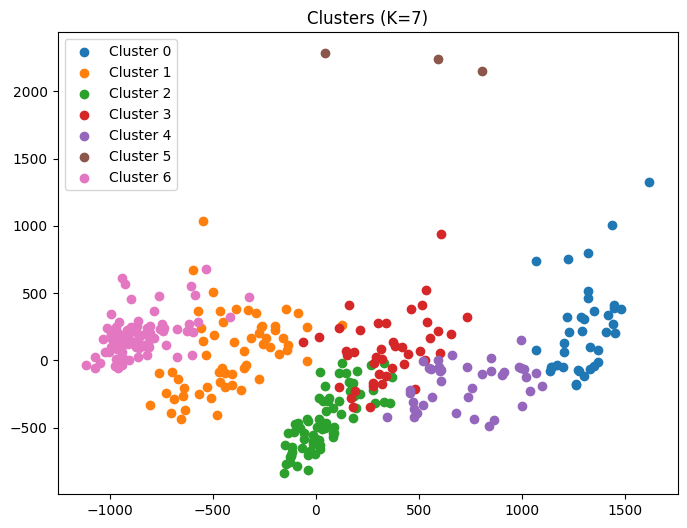

Cluster Labels (K=7): [0 0 0 3 3 0 2 2 0 0 3 2 2 3 2 0 0 2 2 2 2 2 0 0 2 2 3 2 0 0 2 3 2 2 2 0 0
 2 2 2 3 2 0 0 2 2 2 2 0 0 2 2 2 2 4 0 2 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2
 2 0 0 2 2 2 2 2 4 2 2 4 0 0 0 2 2 2 2 0 0 2 2 2 2 2 4 0 2 2 2 2 2 4 0 2 2
 2 2 2 4 4 6 6 6 6 6 3 4 6 6 6 3 1 3 4 6 6 3 4 6 6 6 6 6 3 4 6 6 6 6 6 3 4
 6 6 6 6 6 3 4 6 6 6 6 1 3 4 6 6 6 6 3 0 4 6 6 6 1 1 3 5 1 6 1 3 3 1 1 1 1
 1 3 3 1 1 1 1 1 3 3 1 3 3 3 1 1 1 5 3 4 6 1 1 6 1 3 4 6 6 6 6 6 3 4 6 6 6
 6 6 3 4 6 6 6 6 6 3 6 3 4 6 6 6 6 6 3 4 6 6 6 6 3 4 6 6 6 6 6 5 6 6 6 3 4
 6 6 6 6 6 3 4 6 6 6 6 1 3 4 6 6 6 6 3 4 1 1 1 1 4 4 1 1 1 1 4 4 1 1 1 1 1
 4 4 1 1 1 1 1 4 4 1 1 1 1 1 4 0 1 1 1 1 4 4 1 1 1 1 1 4 4 1 1 1 3 0 0 0 3
 3 3 3 0]
Number of Clusters: 7
Silhouette Score: 0.20989766932629575
Davies-Bouldin Score: 1.5554611268064744
Calinski-Harabasz Score: 102.58891291466065
--------------------------------------------------


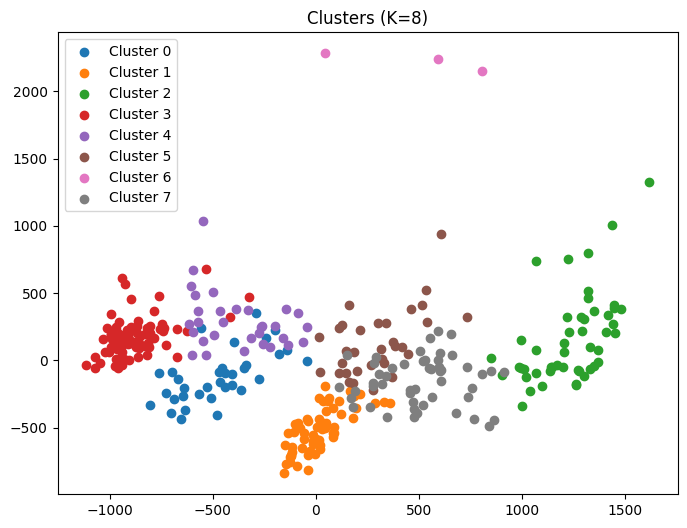

Cluster Labels (K=8): [2 2 2 5 7 2 1 1 2 2 5 5 5 5 5 2 2 1 1 1 1 1 2 2 5 1 5 1 2 2 5 5 5 5 1 2 2
 5 1 1 5 1 2 2 1 1 1 1 2 2 1 1 1 1 2 2 1 1 1 1 5 2 2 1 1 1 5 1 2 2 1 1 1 1
 1 2 2 1 1 1 1 1 2 1 1 2 2 2 2 5 1 1 1 2 2 1 1 1 1 1 2 2 1 1 1 1 1 2 2 1 1
 1 1 1 2 7 3 3 3 3 3 7 7 3 3 3 5 4 7 7 3 3 7 7 3 3 3 3 3 7 7 3 3 3 3 3 5 7
 3 3 3 3 3 5 7 3 4 3 3 4 5 7 3 3 3 3 5 2 7 3 4 3 4 4 5 6 4 4 4 5 7 4 4 4 4
 4 5 7 4 4 4 4 4 5 5 4 4 7 7 4 4 4 6 7 7 4 4 4 4 4 5 7 3 3 3 3 3 7 7 3 3 3
 3 3 7 7 3 3 3 3 4 7 3 7 7 3 3 3 3 3 7 7 3 3 3 3 7 7 3 3 3 3 3 6 3 3 3 7 7
 3 3 3 3 3 5 7 3 3 3 3 4 7 7 3 3 3 3 7 7 0 0 0 0 2 7 0 0 0 0 7 7 0 0 0 0 0
 7 7 0 0 0 0 0 7 2 0 0 0 0 0 2 2 0 0 0 5 7 2 0 0 0 0 0 7 2 0 0 0 5 2 2 2 5
 7 7 7 2]
Number of Clusters: 8
Silhouette Score: 0.22360715189643543
Davies-Bouldin Score: 1.5447150002651042
Calinski-Harabasz Score: 95.5547658798644
--------------------------------------------------


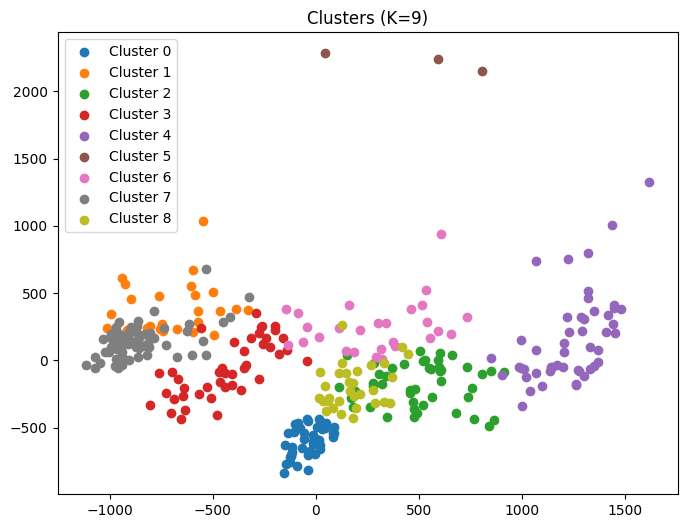

Cluster Labels (K=9): [4 4 4 8 2 4 8 8 4 4 6 8 8 8 8 4 4 8 8 0 0 0 4 4 8 8 6 8 4 4 8 6 8 8 8 4 4
 8 8 8 6 8 4 4 8 8 0 0 4 4 0 0 0 8 4 4 0 0 8 0 8 4 4 0 8 8 8 0 4 4 0 0 0 0
 0 4 4 0 0 8 0 0 4 0 0 4 4 4 4 8 0 0 0 4 4 0 0 0 0 0 4 4 0 0 0 0 0 4 4 0 0
 0 0 0 4 2 7 7 7 7 7 6 2 7 7 1 6 3 2 2 7 7 2 2 7 7 7 7 7 2 2 7 7 1 7 1 6 2
 7 7 1 1 1 6 2 7 1 7 7 1 6 2 7 7 7 7 6 4 2 1 1 7 1 1 6 5 1 1 7 6 6 1 1 3 3
 3 6 6 3 6 3 6 6 6 6 6 6 6 2 3 3 3 5 2 2 7 7 7 7 1 6 2 7 7 7 7 1 2 2 7 7 7
 7 1 2 2 7 7 7 7 1 2 7 2 2 7 7 1 7 7 2 2 7 7 7 7 2 2 7 7 7 7 7 5 7 7 7 2 2
 7 7 7 7 1 6 2 7 7 7 1 1 2 2 1 7 7 7 2 2 3 3 3 3 4 2 3 3 3 3 2 2 3 3 3 3 3
 2 2 3 3 3 3 3 2 4 3 3 3 3 3 4 4 3 3 3 8 2 4 3 3 3 3 3 2 4 3 3 3 6 4 4 4 6
 2 2 2 4]
Number of Clusters: 9
Silhouette Score: 0.18967095442166235
Davies-Bouldin Score: 1.8283692395954985
Calinski-Harabasz Score: 85.50785029549314
--------------------------------------------------


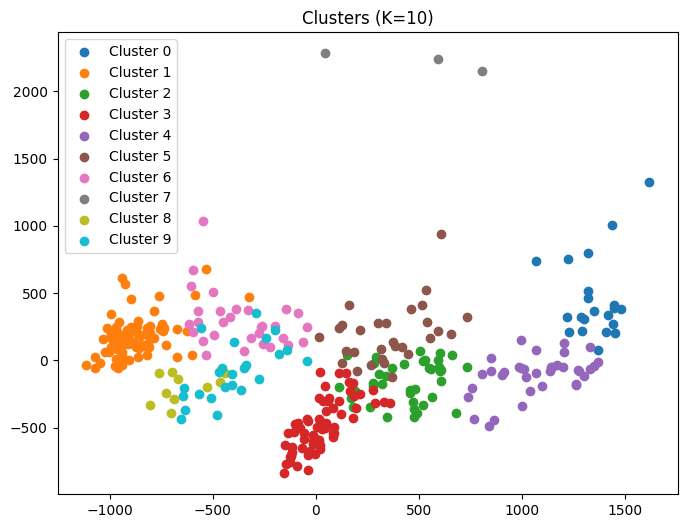

Cluster Labels (K=10): [0 0 0 5 2 0 3 3 0 0 5 5 3 5 3 0 0 3 3 3 3 3 4 0 5 3 5 3 0 0 3 5 5 3 3 0 0
 3 3 3 5 3 4 0 3 3 3 3 4 4 3 3 3 3 4 4 3 3 3 3 5 4 4 3 3 3 3 3 4 4 3 3 3 3
 3 4 4 3 3 3 3 3 4 3 3 4 0 4 0 5 3 3 3 4 4 3 3 3 3 3 4 4 3 3 3 3 3 4 4 3 3
 3 3 3 4 2 1 1 1 1 1 2 2 1 1 1 5 6 2 2 1 1 2 2 1 1 1 1 1 2 2 1 1 1 1 1 5 2
 1 1 1 1 1 5 2 1 1 1 1 6 5 2 1 1 1 1 5 0 2 1 6 1 6 6 5 7 6 6 6 5 5 6 6 6 6
 6 5 5 6 6 6 6 6 5 5 6 6 5 2 6 6 6 7 2 2 6 6 6 1 6 5 2 1 6 1 1 1 2 2 1 1 1
 1 1 2 2 1 1 1 1 6 2 1 2 2 1 1 1 1 1 2 2 1 1 1 1 2 2 1 1 1 1 1 7 1 1 1 2 2
 1 1 1 1 1 5 2 1 1 1 1 6 2 2 1 1 1 1 2 4 8 8 9 9 4 4 9 8 8 9 2 4 8 8 8 9 9
 4 4 9 9 9 9 9 4 4 8 9 9 9 9 4 4 9 9 9 5 4 4 8 8 9 9 9 4 4 9 9 9 5 0 0 0 5
 2 2 2 0]
Number of Clusters: 10
Silhouette Score: 0.19571481277333996
Davies-Bouldin Score: 1.7586017814289732
Calinski-Harabasz Score: 80.02434157725006
--------------------------------------------------


In [57]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

num_clusters_range = range(2, 11)

for n_clusters in num_clusters_range:
    SC_scores = []  # Initialize for each n_clusters
    DB_scores = []  # Initialize for each n_clusters
    CH_scores = []  # Initialize for each n_clusters

    clusters = None
    vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0], :]
    days_not_nans = days[np.where(nans_per_day == 0)[0]]

    # Perform clustering
    cluster_labels = GaussianMixture(n_components=n_clusters).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans) # Check parameters at https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py

    # Calculate the Silhouette Score
    SC = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
    SC_scores.append(SC)

    # Calculate the Davies-Bouldin Score
    DB = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
    DB_scores.append(DB)

    # Calculate the Calinski-Harabasz Score
    CH = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
    CH_scores.append(CH)

    # Visualize clusters using PCA (2D plot)
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(vectorized_day_dataset_no_nans)

    # Create a scatter plot with cluster labels
    plt.figure(figsize=(8, 6))
    for cluster_num in range(n_clusters):
        cluster_points = reduced_data[cluster_labels == cluster_num]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_num}')

    plt.title(f'Clusters (K={n_clusters})')
    plt.legend()
    plt.show()

    # Print cluster labels for data points
    print(f'Cluster Labels (K={n_clusters}): {cluster_labels}')

    # Print cluster quality scores
    print(f'Number of Clusters: {n_clusters}')
    print('Silhouette Score:', SC)
    print('Davies-Bouldin Score:', DB)
    print('Calinski-Harabasz Score:', CH)
    print('-' * 50)




### GaussianMixture Plot

In [77]:
n_clusters = 7
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

if clusters is not None:
  cluster_labels = clusters.labels_

cluster_labels = GaussianMixture(n_components=n_clusters).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans) #check the parameters at  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py

# Initialize a list to store centroid data
centroids = []
n_clusters_t = len(np.unique(cluster_labels))

# Import the pairwise_distances function from scikit-learn's metrics library
import sklearn.metrics.pairwise as dis_lib

# Define a function to find the closest centroid to a new data point within a specified day-time interval range
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    # Iterate through each centroid
    for i in range(0, len(centroids)):
        # Calculate the Euclidean distance between the centroid and the new data point
        ed_t = dis_lib.paired_distances(centroids[i], new_day, metric='euclidean')

        # Check if the current centroid is closer than the previously closest one
        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid


# Calculate centroids for each cluster
for i in range(0, n_clusters_t):
    centroid = np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).reshape(1, nintvals)
    centroids.append(centroid)

# Define the number of past intervals to consider for classification
n_past_intervals_for_classification = 5

# Initialize variables to calculate accuracy metrics
total_mae = 0
total_mape = 0
prediction_counts = 0

# Loop through each day in the evaluation dataset with no missing values
for i in range(0, ndays_eval_not_nans):
    # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
    for j in range(n_past_intervals_for_classification, nintvals - 1):
        # Find the closest centroid for the current data point
        centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)

        # Predict the value for the next interval
        predicted_value = centroids[centroid_index][0, j + 1]

        # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
        mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
        mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])

        # Accumulate MAE, MAPE, and count of predictions
        total_mae += mae_t
        total_mape += mape_t
        prediction_counts += 1

# Calculate and print the prediction accuracy metrics
print('Prediction accuracy MAE:', total_mae / prediction_counts)
print('Prediction accuracy MAPE:', total_mape / prediction_counts)

Prediction accuracy MAE: 25.18422945577506
Prediction accuracy MAPE: 0.2497481206914022


cluster_id_weekdays_share [6, 34, 32, 9, 80, 74, 1]
cluster_id_weekend_share [43, 0, 0, 56, 0, 0, 2]
111


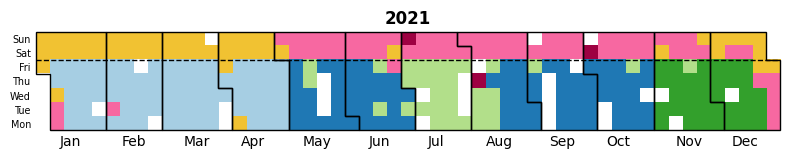

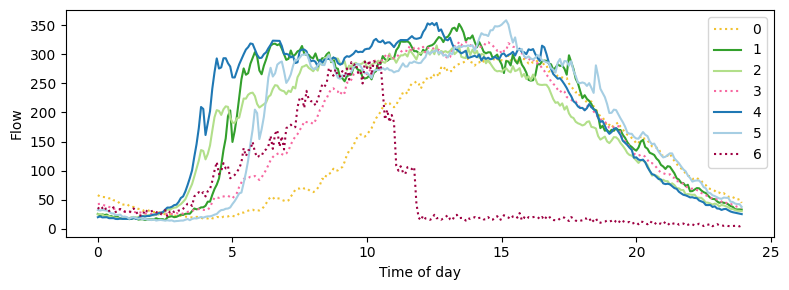

In [78]:
# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.